In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist, mnist
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import wandb

# All Function we use, activations
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    clip_x = np.clip(x, -50, 50)  # After custom runs, i limited
    return 1 / (1 + np.exp(-clip_x))

def tanh(x):
    clip_x = np.clip(x, -20, 20)
    return np.tanh(clip_x)

def identity(x):
    return x

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

# -------------------------
# Neural Network Class
# -------------------------
class NeuralNetwork:
    def __init__(self, config):
        """ Best one
        config: dictionary of hyperparameters. For example:
          {
             'inp_size': 784,
             'num_hidden_layers': 3,
             'hidden_size': 64,
             'out_size': 10,
             'batch_sz': 32,
             'lr': 1e-3,
             'weight_init': 'xavier',   # or "random"
             'optimizer': 'adam',        # options: sgd, momentum, nag, rmsprop, adam, nadam
             'epochs': 5,
             'activation': 'relu',       # activation function for hidden layers
             'loss_type': 'cross_entropy',  # or "mean_squared_error"
             'weight_decay': 0.0005,
             'dataset_choice': 'fashion',   # 'fashion' or 'mnist'
             'use_wandb_flag': True,
             'b1': 0.9, 'b2': 0.999, 'beta': 0.9,
             'eps': 1e-8
          }
        """
        self.config = config
        self.inp_size = config['inp_size']
        self.out_size = config['out_size']
        self.num_hidden_layers = config['num_hidden_layers']
        self.hidden_size = config['hidden_size']
        self.batch_sz = config['batch_sz']
        self.lr = config['lr']
        self.weight_init = config['weight_init']
        self.optimizer_choice = config['optimizer']
        self.epochs = config['epochs']
        self.activation = config['activation']
        self.loss_type = config['loss_type']
        self.weight_decay = config['weight_decay']
        self.dataset_choice = config['dataset_choice']
        self.use_wandb_flag = config['use_wandb_flag']
        self.b1 = config.get('b1', 0.9)
        self.b2 = config.get('b2', 0.999)
        self.beta = config.get('beta', 0.9)
        self.eps = config.get('eps', 1e-8)

        self.layer_dims = [self.inp_size] + [self.hidden_size] * self.num_hidden_layers + [self.out_size]
        # Initialize weights and biases for all layers
        self.params = self._initialize_parameters()
        self._prepare_data()

    def _initialize_parameters(self):
        params = {}
        for i in range(1, len(self.layer_dims)):
            fan_in = self.layer_dims[i-1]
            fan_out = self.layer_dims[i]
            if self.weight_init == 'xavier':
                scale = np.sqrt(2 / (fan_in + fan_out))
            else:
                scale = 0.01
            params[i] = {
                'weights': scale * np.random.randn(fan_out, fan_in),
                'biases': np.zeros((fan_out, 1))
            }
        return params

    def _prepare_data(self):
        # Load dataset (Fashion-MNIST or MNIST)
        if self.dataset_choice == 'fashion':
            (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        else:
            (X_train, y_train), (X_test, y_test) = mnist.load_data()

        # Normalize and reshape: flatten 28x28 images to 784 size
        X_train = X_train.reshape(-1, 784).T / 255.0
        X_test = X_test.reshape(-1, 784).T / 255.0

        # Use 10% of training data for validation, splitting as said
        X_train, X_val, y_train, y_val = train_test_split(
            X_train.T, y_train, test_size=0.1, stratify=y_train, random_state=42)
        self.X_train = X_train.T
        self.y_train = y_train
        self.X_val = X_val.T
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test

    def forward_pass(self, X):
        activations = [X]
        L = len(self.params)
        for i in range(1, L + 1):
            W = self.params[i]['weights']
            b = self.params[i]['biases']
            z = np.dot(W, activations[-1]) + b
            if i < L:
                if self.activation == 'relu':
                    a = relu(z)
                elif self.activation == 'sigmoid':
                    a = sigmoid(z)
                elif self.activation == 'tanh':
                    a = tanh(z)
                else:
                    a = identity(z)
            else:
                a = z
            activations.append(a)
        # Softmax to get probabilities
        probs = softmax(activations[-1])
        activations[-1] = probs
        return activations

    def compute_loss_and_accuracy(self, X, y):
        activations = self.forward_pass(X)
        probs = activations[-1]
        predictions = np.argmax(probs, axis=0)
        accuracy = np.mean(predictions == y) * 100
        m = y.shape[0]
        if self.loss_type == 'cross_entropy':
            loss = -np.mean(np.log(probs[y, range(m)] + 1e-9))
        else:
            y_onehot = np.eye(self.out_size)[y].T
            loss = np.mean((probs - y_onehot) ** 2)
        return accuracy, loss

    def backward_pass(self, activations, y):
        gradients = {}
        m = y.shape[0]
        L = len(self.params)
        y_onehot = np.eye(self.out_size)[y].T
        delta = activations[-1] - y_onehot  # softmax + cross entropy derivative

        for i in reversed(range(1, L + 1)):
            a_prev = activations[i-1]
            gradients[i] = {
                'dW': np.dot(delta, a_prev.T) / m + self.weight_decay * self.params[i]['weights'],
                'db': np.sum(delta, axis=1, keepdims=True) / m
            }
            if i > 1:
                W = self.params[i]['weights']
                delta = np.dot(W.T, delta)
                if self.activation == 'relu':
                    delta = delta * (a_prev > 0)
                elif self.activation == 'sigmoid':
                    delta = delta * (a_prev * (1 - a_prev))
                elif self.activation == 'tanh':
                    delta = delta * (1 - a_prev**2)
        return gradients

    def update_parameters_sgd(self, gradients):
        for i in self.params:
            self.params[i]['weights'] -= self.lr * gradients[i]['dW']
            self.params[i]['biases']  -= self.lr * gradients[i]['db']

    def update_parameters_momentum(self, gradients, v, beta):
        for i in self.params:
            v[i]['dW'] = beta * v[i]['dW'] + (1 - beta) * gradients[i]['dW']
            v[i]['db'] = beta * v[i]['db'] + (1 - beta) * gradients[i]['db']
            self.params[i]['weights'] -= self.lr * v[i]['dW']
            self.params[i]['biases']  -= self.lr * v[i]['db']
        return v

    def update_parameters_rmsprop(self, gradients, s, beta):
        for i in self.params:
            s[i]['dW'] = beta * s[i]['dW'] + (1 - beta) * (gradients[i]['dW'] ** 2)
            s[i]['db'] = beta * s[i]['db'] + (1 - beta) * (gradients[i]['db'] ** 2)
            self.params[i]['weights'] -= self.lr * gradients[i]['dW'] / (np.sqrt(s[i]['dW']) + self.eps)
            self.params[i]['biases']  -= self.lr * gradients[i]['db'] / (np.sqrt(s[i]['db']) + self.eps)
        return s

    def update_parameters_adam(self, gradients, v, s, t):
        for i in self.params:
            v[i]['dW'] = self.b1 * v[i]['dW'] + (1 - self.b1) * gradients[i]['dW']
            v[i]['db'] = self.b1 * v[i]['db'] + (1 - self.b1) * gradients[i]['db']
            s[i]['dW'] = self.b2 * s[i]['dW'] + (1 - self.b2) * (gradients[i]['dW'] ** 2)
            s[i]['db'] = self.b2 * s[i]['db'] + (1 - self.b2) * (gradients[i]['db'] ** 2)
            v_corr_W = v[i]['dW'] / (1 - self.b1 ** t)
            v_corr_b = v[i]['db'] / (1 - self.b1 ** t)
            s_corr_W = s[i]['dW'] / (1 - self.b2 ** t)
            s_corr_b = s[i]['db'] / (1 - self.b2 ** t)
            self.params[i]['weights'] -= self.lr * v_corr_W / (np.sqrt(s_corr_W) + self.eps)
            self.params[i]['biases']  -= self.lr * v_corr_b / (np.sqrt(s_corr_b) + self.eps)
        return v, s
    def update_parameters_nesterov(self, gradients, v, beta):
        for i in self.params:
            # Update momentum using the current gradient
            v[i]['dW'] = beta * v[i]['dW'] + (1 - beta) * gradients[i]['dW']
            v[i]['db'] = beta * v[i]['db'] + (1 - beta) * gradients[i]['db']
            # Nesterov update: incorporate the lookahead momentum term along with the gradient
            self.params[i]['weights'] -= self.lr * (beta * v[i]['dW'] + gradients[i]['dW'])
            self.params[i]['biases']  -= self.lr * (beta * v[i]['db'] + gradients[i]['db'])
        return v

    def update_parameters_nadam(self, gradients, v, s, t):
        for i in self.params:
            # Update first moment estimate
            v[i]['dW'] = self.b1 * v[i]['dW'] + (1 - self.b1) * gradients[i]['dW']
            v[i]['db'] = self.b1 * v[i]['db'] + (1 - self.b1) * gradients[i]['db']
            # Bias-corrected first moment estimates
            m_hat_W = v[i]['dW'] / (1 - self.b1 ** t)
            m_hat_b = v[i]['db'] / (1 - self.b1 ** t)

            # Update second moment estimate
            s[i]['dW'] = self.b2 * s[i]['dW'] + (1 - self.b2) * (gradients[i]['dW'] ** 2)
            s[i]['db'] = self.b2 * s[i]['db'] + (1 - self.b2) * (gradients[i]['db'] ** 2)
            s_hat_W = s[i]['dW'] / (1 - self.b2 ** t)
            s_hat_b = s[i]['db'] / (1 - self.b2 ** t)

            # Nadam have that lookahead correction:
            m_bar_W = (self.b1 * m_hat_W + (1 - self.b1) * gradients[i]['dW'] / (1 - self.b1 ** t))
            m_bar_b = (self.b1 * m_hat_b + (1 - self.b1) * gradients[i]['db'] / (1 - self.b1 ** t))

            # Update parameters using the Nadam rule
            self.params[i]['weights'] -= self.lr * m_bar_W / (np.sqrt(s_hat_W) + self.eps)
            self.params[i]['biases']  -= self.lr * m_bar_b / (np.sqrt(s_hat_b) + self.eps)
        return v, s


    def fit(self):
        if self.optimizer_choice == 'sgd':
            self._train_sgd()
        elif self.optimizer_choice == 'momentum':
            self._train_momentum()
        elif self.optimizer_choice == 'rmsprop':
            self._train_rmsprop()
        elif self.optimizer_choice == 'adam':
            self._train_adam()
        elif self.optimizer_choice == 'nesterov':
            self._train_nesterov()
        elif self.optimizer_choice == 'nadam':
            self._train_nadam()

    def _train_sgd(self):
        for epoch in range(self.epochs):
            permutation = np.random.permutation(self.X_train.shape[1])
            X_shuffled = self.X_train[:, permutation]
            y_shuffled = self.y_train[permutation]
            for i in range(0, self.X_train.shape[1], self.batch_sz):
                X_batch = X_shuffled[:, i:i+self.batch_sz]
                y_batch = y_shuffled[i:i+self.batch_sz]
                activations = self.forward_pass(X_batch)
                grads = self.backward_pass(activations, y_batch)
                self.update_parameters_sgd(grads)
            train_acc, train_loss = self.compute_loss_and_accuracy(self.X_train, self.y_train)
            val_acc, val_loss = self.compute_loss_and_accuracy(self.X_val, self.y_val)
            if self.use_wandb_flag:
                wandb.log({"epoch": epoch, "loss": train_loss, "accuracy": train_acc,
                           "val_loss": val_loss, "val_accuracy": val_acc})
            print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
                  f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

    def _train_momentum(self):
        v = {i: {'dW': np.zeros_like(self.params[i]['weights']),
                 'db': np.zeros_like(self.params[i]['biases'])} for i in self.params}
        for epoch in range(self.epochs):
            permutation = np.random.permutation(self.X_train.shape[1])
            X_shuffled = self.X_train[:, permutation]
            y_shuffled = self.y_train[permutation]
            for i in range(0, self.X_train.shape[1], self.batch_sz):
                X_batch = X_shuffled[:, i:i+self.batch_sz]
                y_batch = y_shuffled[i:i+self.batch_sz]
                activations = self.forward_pass(X_batch)
                grads = self.backward_pass(activations, y_batch)
                v = self.update_parameters_momentum(grads, v, self.beta)
            train_acc, train_loss = self.compute_loss_and_accuracy(self.X_train, self.y_train)
            val_acc, val_loss = self.compute_loss_and_accuracy(self.X_val, self.y_val)
            if self.use_wandb_flag:
                wandb.log({"epoch": epoch, "loss": train_loss, "accuracy": train_acc,
                           "val_loss": val_loss, "val_accuracy": val_acc})
            print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
                  f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

    def _train_rmsprop(self):
        s = {i: {'dW': np.zeros_like(self.params[i]['weights']),
                 'db': np.zeros_like(self.params[i]['biases'])} for i in self.params}
        for epoch in range(self.epochs):
            permutation = np.random.permutation(self.X_train.shape[1])
            X_shuffled = self.X_train[:, permutation]
            y_shuffled = self.y_train[permutation]
            for i in range(0, self.X_train.shape[1], self.batch_sz):
                X_batch = X_shuffled[:, i:i+self.batch_sz]
                y_batch = y_shuffled[i:i+self.batch_sz]
                activations = self.forward_pass(X_batch)
                grads = self.backward_pass(activations, y_batch)
                s = self.update_parameters_rmsprop(grads, s, self.beta)
            train_acc, train_loss = self.compute_loss_and_accuracy(self.X_train, self.y_train)
            val_acc, val_loss = self.compute_loss_and_accuracy(self.X_val, self.y_val)
            if self.use_wandb_flag:
                wandb.log({"epoch": epoch, "loss": train_loss, "accuracy": train_acc,
                           "val_loss": val_loss, "val_accuracy": val_acc})
            print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
                  f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

    def _train_adam(self):
        v = {i: {'dW': np.zeros_like(self.params[i]['weights']),
                 'db': np.zeros_like(self.params[i]['biases'])} for i in self.params}
        s = {i: {'dW': np.zeros_like(self.params[i]['weights']),
                 'db': np.zeros_like(self.params[i]['biases'])} for i in self.params}
        t = 1
        for epoch in range(self.epochs):
            permutation = np.random.permutation(self.X_train.shape[1])
            X_shuffled = self.X_train[:, permutation]
            y_shuffled = self.y_train[permutation]
            for i in range(0, self.X_train.shape[1], self.batch_sz):
                X_batch = X_shuffled[:, i:i+self.batch_sz]
                y_batch = y_shuffled[i:i+self.batch_sz]
                activations = self.forward_pass(X_batch)
                grads = self.backward_pass(activations, y_batch)
                v, s = self.update_parameters_adam(grads, v, s, t)
                t += 1
            train_acc, train_loss = self.compute_loss_and_accuracy(self.X_train, self.y_train)
            val_acc, val_loss = self.compute_loss_and_accuracy(self.X_val, self.y_val)
            if self.use_wandb_flag:
                wandb.log({"epoch": epoch, "loss": train_loss, "accuracy": train_acc,
                           "val_loss": val_loss, "val_accuracy": val_acc})
            print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
                  f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

    def _train_nesterov(self):
        # first of all, give momentum dvalue as zero
        v = {i: {'dW': np.zeros_like(self.params[i]['weights']),
                'db': np.zeros_like(self.params[i]['biases'])} for i in self.params}
        for epoch in range(self.epochs):
            permutation = np.random.permutation(self.X_train.shape[1])
            X_shuffled = self.X_train[:, permutation]
            y_shuffled = self.y_train[permutation]
            for i in range(0, self.X_train.shape[1], self.batch_sz):
                X_batch = X_shuffled[:, i:i+self.batch_sz]
                y_batch = y_shuffled[i:i+self.batch_sz]
                activations = self.forward_pass(X_batch)
                grads = self.backward_pass(activations, y_batch)
                v = self.update_parameters_nesterov(grads, v, self.beta)
            train_acc, train_loss = self.compute_loss_and_accuracy(self.X_train, self.y_train)
            val_acc, val_loss = self.compute_loss_and_accuracy(self.X_val, self.y_val)
            if self.use_wandb_flag:
                wandb.log({"epoch": epoch, "loss": train_loss, "accuracy": train_acc,
                          "val_loss": val_loss, "val_accuracy": val_acc})
            print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
                  f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

    def _train_nadam(self):
        # Initialize first and second moment dictionaries with zeros
        v = {i: {'dW': np.zeros_like(self.params[i]['weights']),
                'db': np.zeros_like(self.params[i]['biases'])} for i in self.params}
        s = {i: {'dW': np.zeros_like(self.params[i]['weights']),
                'db': np.zeros_like(self.params[i]['biases'])} for i in self.params}
        t = 1
        for epoch in range(self.epochs):
            permutation = np.random.permutation(self.X_train.shape[1])
            X_shuffled = self.X_train[:, permutation]
            y_shuffled = self.y_train[permutation]
            for i in range(0, self.X_train.shape[1], self.batch_sz):
                X_batch = X_shuffled[:, i:i+self.batch_sz]
                y_batch = y_shuffled[i:i+self.batch_sz]
                activations = self.forward_pass(X_batch)
                grads = self.backward_pass(activations, y_batch)
                v, s = self.update_parameters_nadam(grads, v, s, t)
                t += 1
            train_acc, train_loss = self.compute_loss_and_accuracy(self.X_train, self.y_train)
            val_acc, val_loss = self.compute_loss_and_accuracy(self.X_val, self.y_val)
            if self.use_wandb_flag:
                wandb.log({"epoch": epoch, "loss": train_loss, "accuracy": train_acc,
                          "val_loss": val_loss, "val_accuracy": val_acc})
            print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
                  f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")


    def predict(self, X):
        activations = self.forward_pass(X)
        probs = activations[-1]
        return np.argmax(probs, axis=0)

    def log_confusion_matrix(self):
        preds = self.predict(self.X_test)
        if self.dataset_choice == 'fashion':
            class_names = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
                           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
        else:
            class_names = [str(i) for i in range(10)]
        cm = confusion_matrix(self.y_test, preds)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        filename = "confusion_matrix.png"
        plt.savefig(filename)
        plt.close()
        if self.use_wandb_flag:
            wandb.log({"Confusion Matrix": wandb.Image(filename)})
        else:
            plt.show()

In [32]:
wandb.init(project="Deep_Learning_Assignment1_cs24m022", name="Q1_Images")

# Loaded fashion mnist data
(X_train, Y_train), (_, _) = fashion_mnist.load_data()

# All ten classes, I am image classifying it
class_names = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]


fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns for 10 classes
for i in range(10):
    class_index = np.where(Y_train == i)[0][0]
    image = X_train[class_index]

    # Plot the image in grayscale
    ax = axes[i // 5, i % 5]
    ax.imshow(image, cmap="gray")
    ax.set_title(class_names[i])
    ax.axis("off")

# storing all images to Wandb
wandb.log({"Classify 10 images": wandb.Image(fig)})
plt.close()
wandb.finish()

In [33]:
sweep_config = {
    "method": "bayes",  # Using bayes search
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
        "loss_type": {"values": ["cross_entropy", "mean_squared_error"]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="Deep_Learning_Assignment1_cs24m022")
print("Sweep ID:", sweep_id)

def sweep_train():
    # Initialize the run.
    run = wandb.init(project="Deep_Learning_Assignment1_cs24m022")
    config = run.config
    run_name = (
        f"hl_{config.num_hidden_layers}_"
        f"bs_{config.batch_size}_"
        f"hs_{config.hidden_size}_"
        f"loss_{config.loss_type}_"
        f"init_{config.weight_init}_"
        f"ac_{config.activation}_"
        f"wd_{config.weight_decay}_"
        f"lr_{config.learning_rate}_"
        f"opt_{config.optimizer}"
    )
    wandb.run.name = run_name

    model_config = {
        'inp_size': 784,
        'num_hidden_layers': config.num_hidden_layers,
        'hidden_size': config.hidden_size,
        'out_size': 10,
        'batch_sz': config.batch_size,
        'lr': config.learning_rate,
        'weight_init': config.weight_init,
        'optimizer': config.optimizer,
        'epochs': config.epochs,
        'activation': config.activation,
        'loss_type': config.loss_type,  # "cross_entropy" or "mean_squared_error"
        'weight_decay': config.weight_decay,
        'dataset_choice': 'fashion',
        'use_wandb_flag': True,
        'b1': 0.9,
        'b2': 0.999,
        'beta': 0.9,
        'eps': 1e-8
    }

    model = NeuralNetwork(model_config)
    model.fit()

    # Computing final thing
    val_acc, val_loss = model.compute_loss_and_accuracy(model.X_val, model.y_val)
    wandb.log({"final_val_accuracy": val_acc, "final_val_loss": val_loss})

    # Generate and save the confusion matrix image, future use
    model.log_confusion_matrix()

    artifact = wandb.Artifact("confusion_matrix", type="image")
    artifact.add_file("confusion_matrix.png")
    artifact.metadata = {"val_accuracy": val_acc}
    wandb.log_artifact(artifact)

    wandb.finish()


Create sweep with ID: 9r7mtgh0
Sweep URL: https://wandb.ai/cs24m022-iit-madras-foundation/Deep_Learning_Assignment1_cs24m022/sweeps/9r7mtgh0
Sweep ID: 9r7mtgh0


In [4]:
wandb.agent(sweep_id, function=sweep_train, count = 100)

wandb: Agent Starting Run: ct33713t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 25.25%, Loss: 0.0885 | Val Acc: 25.27%, Loss: 0.0885
Epoch 1: Train Acc: 40.10%, Loss: 0.0823 | Val Acc: 39.47%, Loss: 0.0824
Epoch 2: Train Acc: 39.49%, Loss: 0.0742 | Val Acc: 39.37%, Loss: 0.0743
Epoch 3: Train Acc: 43.45%, Loss: 0.0668 | Val Acc: 43.57%, Loss: 0.0669
Epoch 4: Train Acc: 54.88%, Loss: 0.0615 | Val Acc: 55.48%, Loss: 0.0615


accuracy,▁▅▄▅█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▂▁
val_accuracy,▁▄▄▅█
val_loss,█▆▄▂▁
accuracy,54.87593
epoch,4
final_val_accuracy,55.48333
final_val_loss,0.06154


wandb: Agent Starting Run: ypzd7jv1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 10.00%, Loss: 2.3152 | Val Acc: 10.00%, Loss: 2.3152
Epoch 1: Train Acc: 10.01%, Loss: 2.3032 | Val Acc: 10.00%, Loss: 2.3032
Epoch 2: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 3: Train Acc: 10.40%, Loss: 2.3026 | Val Acc: 10.40%, Loss: 2.3026
Epoch 4: Train Acc: 9.98%, Loss: 2.3026 | Val Acc: 9.98%, Loss: 2.3026
Epoch 5: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 6: Train Acc: 7.90%, Loss: 2.3026 | Val Acc: 7.72%, Loss: 2.3026
Epoch 7: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 8: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 9: Train Acc: 9.99%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026


accuracy,▇▇▇█▇▇▁▇▇▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▇▇▇█▇▇▁▇▇▇
val_loss,█▁▁▁▁▁▁▁▁▁
accuracy,9.98704
epoch,9
final_val_accuracy,10
final_val_loss,2.30256


wandb: Agent Starting Run: gpyiaemn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 1: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 2: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 3: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 4: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 5: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 6: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 7: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 8: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026
Epoch 9: Train Acc: 10.00%, Loss: 2.3026 | Val Acc: 10.00%, Loss: 2.3026


accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,████▁▁▁▁█▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,████▁▁▁▁█▁
accuracy,10
epoch,9
final_val_accuracy,10
final_val_loss,2.30258


wandb: Agent Starting Run: l77h0dko with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 81.48%, Loss: 0.0268 | Val Acc: 81.97%, Loss: 0.0262
Epoch 1: Train Acc: 84.14%, Loss: 0.0227 | Val Acc: 84.40%, Loss: 0.0222
Epoch 2: Train Acc: 85.09%, Loss: 0.0213 | Val Acc: 85.50%, Loss: 0.0210
Epoch 3: Train Acc: 85.90%, Loss: 0.0201 | Val Acc: 86.10%, Loss: 0.0201
Epoch 4: Train Acc: 86.52%, Loss: 0.0192 | Val Acc: 86.97%, Loss: 0.0189
Epoch 5: Train Acc: 87.02%, Loss: 0.0185 | Val Acc: 87.28%, Loss: 0.0184
Epoch 6: Train Acc: 86.97%, Loss: 0.0185 | Val Acc: 87.10%, Loss: 0.0185
Epoch 7: Train Acc: 87.56%, Loss: 0.0177 | Val Acc: 87.73%, Loss: 0.0178
Epoch 8: Train Acc: 87.74%, Loss: 0.0174 | Val Acc: 87.88%, Loss: 0.0175
Epoch 9: Train Acc: 87.66%, Loss: 0.0175 | Val Acc: 87.42%, Loss: 0.0181


accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇██▇
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,87.66481
epoch,9
final_val_accuracy,87.41667
final_val_loss,0.01811


wandb: Agent Starting Run: ld5vp283 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 81.64%, Loss: 0.0267 | Val Acc: 81.92%, Loss: 0.0264
Epoch 1: Train Acc: 82.91%, Loss: 0.0240 | Val Acc: 83.57%, Loss: 0.0232
Epoch 2: Train Acc: 85.47%, Loss: 0.0208 | Val Acc: 86.18%, Loss: 0.0201
Epoch 3: Train Acc: 85.90%, Loss: 0.0203 | Val Acc: 85.92%, Loss: 0.0201
Epoch 4: Train Acc: 86.99%, Loss: 0.0186 | Val Acc: 87.30%, Loss: 0.0184
Epoch 5: Train Acc: 87.34%, Loss: 0.0182 | Val Acc: 87.27%, Loss: 0.0182
Epoch 6: Train Acc: 88.01%, Loss: 0.0175 | Val Acc: 87.63%, Loss: 0.0177
Epoch 7: Train Acc: 88.14%, Loss: 0.0171 | Val Acc: 88.22%, Loss: 0.0172
Epoch 8: Train Acc: 88.66%, Loss: 0.0164 | Val Acc: 88.28%, Loss: 0.0169
Epoch 9: Train Acc: 88.34%, Loss: 0.0167 | Val Acc: 87.88%, Loss: 0.0172


accuracy,▁▂▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▄▂▂▂▁▁▁
val_accuracy,▁▃▆▅▇▇▇███
val_loss,█▆▃▃▂▂▂▁▁▁
accuracy,88.34259
epoch,9
final_val_accuracy,87.88333
final_val_loss,0.01717


wandb: Agent Starting Run: ewjm9p9q with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.03%, Loss: 0.0252 | Val Acc: 83.18%, Loss: 0.0247
Epoch 1: Train Acc: 85.32%, Loss: 0.0215 | Val Acc: 86.00%, Loss: 0.0209
Epoch 2: Train Acc: 85.98%, Loss: 0.0204 | Val Acc: 86.67%, Loss: 0.0197
Epoch 3: Train Acc: 86.76%, Loss: 0.0193 | Val Acc: 86.80%, Loss: 0.0189
Epoch 4: Train Acc: 87.61%, Loss: 0.0182 | Val Acc: 87.60%, Loss: 0.0181
Epoch 5: Train Acc: 87.83%, Loss: 0.0177 | Val Acc: 87.82%, Loss: 0.0176
Epoch 6: Train Acc: 88.19%, Loss: 0.0171 | Val Acc: 88.02%, Loss: 0.0172
Epoch 7: Train Acc: 88.40%, Loss: 0.0170 | Val Acc: 88.22%, Loss: 0.0171
Epoch 8: Train Acc: 88.84%, Loss: 0.0163 | Val Acc: 88.73%, Loss: 0.0166
Epoch 9: Train Acc: 88.95%, Loss: 0.0161 | Val Acc: 88.62%, Loss: 0.0164


accuracy,▁▄▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▂▁▁
accuracy,88.9463
epoch,9
final_val_accuracy,88.61667
final_val_loss,0.01644


wandb: Agent Starting Run: bnrdsu59 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 34.89%, Loss: 0.0844 | Val Acc: 35.65%, Loss: 0.0844
Epoch 1: Train Acc: 52.22%, Loss: 0.0757 | Val Acc: 52.05%, Loss: 0.0757
Epoch 2: Train Acc: 59.99%, Loss: 0.0654 | Val Acc: 60.08%, Loss: 0.0653
Epoch 3: Train Acc: 63.57%, Loss: 0.0570 | Val Acc: 63.50%, Loss: 0.0570
Epoch 4: Train Acc: 65.66%, Loss: 0.0514 | Val Acc: 66.13%, Loss: 0.0513


accuracy,▁▅▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▂▁
val_accuracy,▁▅▇▇█
val_loss,█▆▄▂▁
accuracy,65.65926
epoch,4
final_val_accuracy,66.13333
final_val_loss,0.05129


wandb: Agent Starting Run: iak5ljy3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 10.00%, Loss: 0.0910 | Val Acc: 10.00%, Loss: 0.0910
Epoch 1: Train Acc: 10.00%, Loss: 0.0904 | Val Acc: 10.00%, Loss: 0.0904
Epoch 2: Train Acc: 10.00%, Loss: 0.0902 | Val Acc: 10.00%, Loss: 0.0902
Epoch 3: Train Acc: 9.07%, Loss: 0.0901 | Val Acc: 9.12%, Loss: 0.0901
Epoch 4: Train Acc: 10.00%, Loss: 0.0900 | Val Acc: 10.00%, Loss: 0.0900


accuracy,███▁█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,███▁█
val_loss,█▄▂▁▁
accuracy,10
epoch,4
final_val_accuracy,10
final_val_loss,0.09003


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uysgdvo5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.11%, Loss: 0.0249 | Val Acc: 83.70%, Loss: 0.0247
Epoch 1: Train Acc: 84.69%, Loss: 0.0223 | Val Acc: 84.97%, Loss: 0.0221
Epoch 2: Train Acc: 86.17%, Loss: 0.0201 | Val Acc: 86.23%, Loss: 0.0199
Epoch 3: Train Acc: 86.70%, Loss: 0.0192 | Val Acc: 86.83%, Loss: 0.0191
Epoch 4: Train Acc: 87.26%, Loss: 0.0183 | Val Acc: 87.42%, Loss: 0.0184


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▁
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
accuracy,87.26481
epoch,4
final_val_accuracy,87.41667
final_val_loss,0.01842


wandb: Agent Starting Run: log2bj5k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 82.50%, Loss: 0.0250 | Val Acc: 83.05%, Loss: 0.0245
Epoch 1: Train Acc: 85.02%, Loss: 0.0214 | Val Acc: 85.45%, Loss: 0.0209
Epoch 2: Train Acc: 85.54%, Loss: 0.0206 | Val Acc: 85.70%, Loss: 0.0202
Epoch 3: Train Acc: 86.64%, Loss: 0.0190 | Val Acc: 86.95%, Loss: 0.0187
Epoch 4: Train Acc: 87.47%, Loss: 0.0181 | Val Acc: 87.28%, Loss: 0.0181
Epoch 5: Train Acc: 87.55%, Loss: 0.0178 | Val Acc: 87.57%, Loss: 0.0180
Epoch 6: Train Acc: 87.43%, Loss: 0.0178 | Val Acc: 87.28%, Loss: 0.0178
Epoch 7: Train Acc: 88.28%, Loss: 0.0168 | Val Acc: 88.42%, Loss: 0.0170
Epoch 8: Train Acc: 88.21%, Loss: 0.0169 | Val Acc: 87.57%, Loss: 0.0173
Epoch 9: Train Acc: 88.70%, Loss: 0.0162 | Val Acc: 88.20%, Loss: 0.0166


accuracy,▁▄▄▆▇▇▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▁▂▁
val_accuracy,▁▄▄▆▇▇▇█▇█
val_loss,█▅▄▃▂▂▂▁▂▁
accuracy,88.7
epoch,9
final_val_accuracy,88.2
final_val_loss,0.01661


wandb: Agent Starting Run: sbjo97ds with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 0: Train Acc: 10.58%, Loss: 0.0900 | Val Acc: 10.43%, Loss: 0.0900
Epoch 1: Train Acc: 10.97%, Loss: 0.0900 | Val Acc: 10.73%, Loss: 0.0900
Epoch 2: Train Acc: 11.39%, Loss: 0.0900 | Val Acc: 11.03%, Loss: 0.0900
Epoch 3: Train Acc: 11.71%, Loss: 0.0900 | Val Acc: 11.57%, Loss: 0.0900
Epoch 4: Train Acc: 12.01%, Loss: 0.0900 | Val Acc: 11.92%, Loss: 0.0900


accuracy,▁▃▅▆█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▃▁
val_accuracy,▁▂▄▆█
val_loss,█▆▄▃▁
accuracy,12.01481
epoch,4
final_val_accuracy,11.91667
final_val_loss,0.09


wandb: Agent Starting Run: q27om8yo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 80.52%, Loss: 0.0287 | Val Acc: 80.67%, Loss: 0.0287
Epoch 1: Train Acc: 83.75%, Loss: 0.0239 | Val Acc: 83.65%, Loss: 0.0236
Epoch 2: Train Acc: 85.16%, Loss: 0.0218 | Val Acc: 85.33%, Loss: 0.0213
Epoch 3: Train Acc: 85.69%, Loss: 0.0208 | Val Acc: 85.80%, Loss: 0.0205
Epoch 4: Train Acc: 85.68%, Loss: 0.0208 | Val Acc: 85.95%, Loss: 0.0206
Epoch 5: Train Acc: 86.13%, Loss: 0.0198 | Val Acc: 86.45%, Loss: 0.0196
Epoch 6: Train Acc: 87.09%, Loss: 0.0187 | Val Acc: 87.25%, Loss: 0.0186
Epoch 7: Train Acc: 87.08%, Loss: 0.0187 | Val Acc: 87.18%, Loss: 0.0187
Epoch 8: Train Acc: 87.49%, Loss: 0.0180 | Val Acc: 87.37%, Loss: 0.0181
Epoch 9: Train Acc: 87.68%, Loss: 0.0177 | Val Acc: 87.85%, Loss: 0.0178


accuracy,▁▄▆▆▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▆▆▇▇▇██
val_loss,█▅▃▃▃▂▂▂▁▁
accuracy,87.68333
epoch,9
final_val_accuracy,87.85
final_val_loss,0.01783


wandb: Agent Starting Run: jc0lbmzk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 81.99%, Loss: 0.0252 | Val Acc: 82.65%, Loss: 0.0244
Epoch 1: Train Acc: 86.22%, Loss: 0.0198 | Val Acc: 86.58%, Loss: 0.0194
Epoch 2: Train Acc: 87.09%, Loss: 0.0185 | Val Acc: 86.93%, Loss: 0.0185
Epoch 3: Train Acc: 87.85%, Loss: 0.0174 | Val Acc: 87.70%, Loss: 0.0176
Epoch 4: Train Acc: 88.25%, Loss: 0.0169 | Val Acc: 87.43%, Loss: 0.0176
Epoch 5: Train Acc: 88.36%, Loss: 0.0167 | Val Acc: 87.85%, Loss: 0.0174
Epoch 6: Train Acc: 89.19%, Loss: 0.0157 | Val Acc: 88.40%, Loss: 0.0167
Epoch 7: Train Acc: 89.06%, Loss: 0.0158 | Val Acc: 88.13%, Loss: 0.0171
Epoch 8: Train Acc: 89.58%, Loss: 0.0150 | Val Acc: 88.60%, Loss: 0.0165
Epoch 9: Train Acc: 90.30%, Loss: 0.0141 | Val Acc: 89.02%, Loss: 0.0159


accuracy,▁▅▅▆▆▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▃▂▂▂▁
val_accuracy,▁▅▆▇▆▇▇▇██
val_loss,█▄▃▂▂▂▂▂▁▁
accuracy,90.29815
epoch,9
final_val_accuracy,89.01667
final_val_loss,0.01592


wandb: Agent Starting Run: 97hhjyl7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.70%, Loss: 0.0234 | Val Acc: 84.20%, Loss: 0.0229
Epoch 1: Train Acc: 85.48%, Loss: 0.0206 | Val Acc: 85.55%, Loss: 0.0204
Epoch 2: Train Acc: 86.53%, Loss: 0.0193 | Val Acc: 86.35%, Loss: 0.0195
Epoch 3: Train Acc: 87.31%, Loss: 0.0180 | Val Acc: 87.27%, Loss: 0.0183
Epoch 4: Train Acc: 87.62%, Loss: 0.0176 | Val Acc: 87.68%, Loss: 0.0178
Epoch 5: Train Acc: 88.24%, Loss: 0.0168 | Val Acc: 88.00%, Loss: 0.0174
Epoch 6: Train Acc: 88.60%, Loss: 0.0164 | Val Acc: 88.08%, Loss: 0.0172
Epoch 7: Train Acc: 88.97%, Loss: 0.0159 | Val Acc: 88.42%, Loss: 0.0168
Epoch 8: Train Acc: 89.19%, Loss: 0.0155 | Val Acc: 88.43%, Loss: 0.0167
Epoch 9: Train Acc: 89.24%, Loss: 0.0153 | Val Acc: 88.42%, Loss: 0.0166


accuracy,▁▃▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,89.23889
epoch,9
final_val_accuracy,88.41667
final_val_loss,0.01658


wandb: Agent Starting Run: gjs5y1pu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 86.04%, Loss: 0.0202 | Val Acc: 85.85%, Loss: 0.0203
Epoch 1: Train Acc: 86.04%, Loss: 0.0198 | Val Acc: 85.33%, Loss: 0.0206
Epoch 2: Train Acc: 88.54%, Loss: 0.0167 | Val Acc: 87.78%, Loss: 0.0175
Epoch 3: Train Acc: 89.88%, Loss: 0.0148 | Val Acc: 88.80%, Loss: 0.0160
Epoch 4: Train Acc: 89.59%, Loss: 0.0148 | Val Acc: 88.38%, Loss: 0.0166
Epoch 5: Train Acc: 90.05%, Loss: 0.0143 | Val Acc: 89.05%, Loss: 0.0161
Epoch 6: Train Acc: 89.62%, Loss: 0.0148 | Val Acc: 87.75%, Loss: 0.0174
Epoch 7: Train Acc: 90.02%, Loss: 0.0143 | Val Acc: 88.63%, Loss: 0.0164
Epoch 8: Train Acc: 91.15%, Loss: 0.0126 | Val Acc: 89.57%, Loss: 0.0154
Epoch 9: Train Acc: 91.26%, Loss: 0.0126 | Val Acc: 89.50%, Loss: 0.0150


accuracy,▁▁▄▆▆▆▆▆██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,██▅▃▃▃▃▃▁▁
val_accuracy,▂▁▅▇▆▇▅▆██
val_loss,██▄▂▃▂▄▃▁▁
accuracy,91.26296
epoch,9
final_val_accuracy,89.5
final_val_loss,0.01503


wandb: Agent Starting Run: hqzcv5gh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.06%, Loss: 0.0252 | Val Acc: 83.30%, Loss: 0.0248
Epoch 1: Train Acc: 84.99%, Loss: 0.0218 | Val Acc: 85.40%, Loss: 0.0213
Epoch 2: Train Acc: 86.03%, Loss: 0.0202 | Val Acc: 86.42%, Loss: 0.0197
Epoch 3: Train Acc: 86.53%, Loss: 0.0195 | Val Acc: 86.38%, Loss: 0.0195
Epoch 4: Train Acc: 87.13%, Loss: 0.0185 | Val Acc: 87.27%, Loss: 0.0184
Epoch 5: Train Acc: 87.64%, Loss: 0.0179 | Val Acc: 87.57%, Loss: 0.0179
Epoch 6: Train Acc: 87.75%, Loss: 0.0179 | Val Acc: 87.08%, Loss: 0.0184
Epoch 7: Train Acc: 87.89%, Loss: 0.0176 | Val Acc: 87.48%, Loss: 0.0179
Epoch 8: Train Acc: 88.68%, Loss: 0.0164 | Val Acc: 88.32%, Loss: 0.0168
Epoch 9: Train Acc: 88.98%, Loss: 0.0159 | Val Acc: 88.50%, Loss: 0.0165


accuracy,▁▃▅▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▄▃▂▂▂▁▁
val_accuracy,▁▄▅▅▆▇▆▇██
val_loss,█▅▄▃▃▂▃▂▁▁
accuracy,88.97963
epoch,9
final_val_accuracy,88.5
final_val_loss,0.01652


wandb: Agent Starting Run: 8770ze89 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 80.27%, Loss: 0.0277 | Val Acc: 80.97%, Loss: 0.0268
Epoch 1: Train Acc: 86.38%, Loss: 0.0196 | Val Acc: 86.48%, Loss: 0.0199
Epoch 2: Train Acc: 87.99%, Loss: 0.0175 | Val Acc: 87.42%, Loss: 0.0182
Epoch 3: Train Acc: 87.92%, Loss: 0.0173 | Val Acc: 87.27%, Loss: 0.0183
Epoch 4: Train Acc: 88.83%, Loss: 0.0160 | Val Acc: 88.03%, Loss: 0.0173


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▁▆▇▇█
val_loss,█▃▂▂▁
accuracy,88.82778
epoch,4
final_val_accuracy,88.03333
final_val_loss,0.01733


wandb: Agent Starting Run: ls76odyt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.79%, Loss: 0.0216 | Val Acc: 85.28%, Loss: 0.0209
Epoch 1: Train Acc: 86.70%, Loss: 0.0192 | Val Acc: 86.87%, Loss: 0.0193
Epoch 2: Train Acc: 87.78%, Loss: 0.0174 | Val Acc: 87.90%, Loss: 0.0175
Epoch 3: Train Acc: 87.90%, Loss: 0.0171 | Val Acc: 87.85%, Loss: 0.0175
Epoch 4: Train Acc: 88.56%, Loss: 0.0164 | Val Acc: 87.95%, Loss: 0.0175


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▂▂▁
val_accuracy,▁▅███
val_loss,█▅▁▁▁
accuracy,88.56111
epoch,4
final_val_accuracy,87.95
final_val_loss,0.01753


wandb: Agent Starting Run: t8iaw178 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 79.63%, Loss: 0.0289 | Val Acc: 79.73%, Loss: 0.0289
Epoch 1: Train Acc: 85.13%, Loss: 0.0215 | Val Acc: 84.47%, Loss: 0.0220
Epoch 2: Train Acc: 85.88%, Loss: 0.0199 | Val Acc: 86.13%, Loss: 0.0200
Epoch 3: Train Acc: 88.11%, Loss: 0.0173 | Val Acc: 86.87%, Loss: 0.0187
Epoch 4: Train Acc: 88.39%, Loss: 0.0166 | Val Acc: 87.47%, Loss: 0.0178
Epoch 5: Train Acc: 89.07%, Loss: 0.0156 | Val Acc: 88.00%, Loss: 0.0173
Epoch 6: Train Acc: 89.63%, Loss: 0.0149 | Val Acc: 88.53%, Loss: 0.0166
Epoch 7: Train Acc: 89.86%, Loss: 0.0145 | Val Acc: 88.20%, Loss: 0.0167
Epoch 8: Train Acc: 90.48%, Loss: 0.0137 | Val Acc: 88.18%, Loss: 0.0167
Epoch 9: Train Acc: 90.83%, Loss: 0.0132 | Val Acc: 88.48%, Loss: 0.0166


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
accuracy,90.83148
epoch,9
final_val_accuracy,88.48333
final_val_loss,0.01658


wandb: Agent Starting Run: bz3lnd9q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 63.16%, Loss: 0.0523 | Val Acc: 63.67%, Loss: 0.0522
Epoch 1: Train Acc: 75.27%, Loss: 0.0342 | Val Acc: 75.60%, Loss: 0.0338
Epoch 2: Train Acc: 78.44%, Loss: 0.0293 | Val Acc: 78.82%, Loss: 0.0288
Epoch 3: Train Acc: 81.03%, Loss: 0.0263 | Val Acc: 81.28%, Loss: 0.0258
Epoch 4: Train Acc: 83.12%, Loss: 0.0242 | Val Acc: 83.60%, Loss: 0.0237
Epoch 5: Train Acc: 84.20%, Loss: 0.0228 | Val Acc: 84.35%, Loss: 0.0224
Epoch 6: Train Acc: 84.87%, Loss: 0.0218 | Val Acc: 84.98%, Loss: 0.0213
Epoch 7: Train Acc: 85.33%, Loss: 0.0210 | Val Acc: 85.60%, Loss: 0.0205
Epoch 8: Train Acc: 85.70%, Loss: 0.0204 | Val Acc: 86.10%, Loss: 0.0198
Epoch 9: Train Acc: 86.17%, Loss: 0.0198 | Val Acc: 86.28%, Loss: 0.0194


accuracy,▁▅▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
accuracy,86.16852
epoch,9
final_val_accuracy,86.28333
final_val_loss,0.01939


wandb: Agent Starting Run: 09st3oyf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 62.63%, Loss: 0.0513 | Val Acc: 62.35%, Loss: 0.0514
Epoch 1: Train Acc: 72.77%, Loss: 0.0332 | Val Acc: 72.68%, Loss: 0.0328
Epoch 2: Train Acc: 80.92%, Loss: 0.0263 | Val Acc: 80.68%, Loss: 0.0265
Epoch 3: Train Acc: 85.64%, Loss: 0.0208 | Val Acc: 85.77%, Loss: 0.0210
Epoch 4: Train Acc: 87.19%, Loss: 0.0185 | Val Acc: 86.78%, Loss: 0.0190
Epoch 5: Train Acc: 87.64%, Loss: 0.0179 | Val Acc: 87.03%, Loss: 0.0187
Epoch 6: Train Acc: 88.84%, Loss: 0.0163 | Val Acc: 87.92%, Loss: 0.0178
Epoch 7: Train Acc: 88.14%, Loss: 0.0170 | Val Acc: 86.88%, Loss: 0.0188
Epoch 8: Train Acc: 88.49%, Loss: 0.0167 | Val Acc: 87.00%, Loss: 0.0186
Epoch 9: Train Acc: 89.50%, Loss: 0.0151 | Val Acc: 88.02%, Loss: 0.0173


accuracy,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇██████
val_loss,█▄▃▂▁▁▁▁▁▁
accuracy,89.49815
epoch,9
final_val_accuracy,88.01667
final_val_loss,0.01727


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kn5a9kkl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.78%, Loss: 0.0235 | Val Acc: 84.33%, Loss: 0.0232
Epoch 1: Train Acc: 86.47%, Loss: 0.0194 | Val Acc: 86.73%, Loss: 0.0192
Epoch 2: Train Acc: 87.37%, Loss: 0.0181 | Val Acc: 87.47%, Loss: 0.0180
Epoch 3: Train Acc: 87.81%, Loss: 0.0173 | Val Acc: 88.28%, Loss: 0.0172
Epoch 4: Train Acc: 88.57%, Loss: 0.0164 | Val Acc: 88.07%, Loss: 0.0170


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▁
val_accuracy,▁▅▇██
val_loss,█▃▂▁▁
accuracy,88.56667
epoch,4
final_val_accuracy,88.06667
final_val_loss,0.01701


wandb: Agent Starting Run: 8uck1jlv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.76%, Loss: 0.0214 | Val Acc: 85.08%, Loss: 0.0209
Epoch 1: Train Acc: 86.65%, Loss: 0.0190 | Val Acc: 86.73%, Loss: 0.0189
Epoch 2: Train Acc: 88.11%, Loss: 0.0168 | Val Acc: 88.13%, Loss: 0.0171
Epoch 3: Train Acc: 88.55%, Loss: 0.0164 | Val Acc: 87.80%, Loss: 0.0171
Epoch 4: Train Acc: 89.84%, Loss: 0.0146 | Val Acc: 88.42%, Loss: 0.0160


accuracy,▁▄▆▆█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▃▃▁
val_accuracy,▁▄▇▇█
val_loss,█▅▃▃▁
accuracy,89.83889
epoch,4
final_val_accuracy,88.41667
final_val_loss,0.01602


wandb: Agent Starting Run: g5r059up with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.49%, Loss: 0.0231 | Val Acc: 83.75%, Loss: 0.0228
Epoch 1: Train Acc: 86.84%, Loss: 0.0189 | Val Acc: 86.58%, Loss: 0.0191
Epoch 2: Train Acc: 88.26%, Loss: 0.0167 | Val Acc: 87.98%, Loss: 0.0168
Epoch 3: Train Acc: 89.02%, Loss: 0.0157 | Val Acc: 88.32%, Loss: 0.0164
Epoch 4: Train Acc: 89.33%, Loss: 0.0154 | Val Acc: 88.48%, Loss: 0.0163


accuracy,▁▅▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
accuracy,89.32778
epoch,4
final_val_accuracy,88.48333
final_val_loss,0.0163


wandb: Agent Starting Run: aj8jkrgm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 74.04%, Loss: 0.0395 | Val Acc: 74.30%, Loss: 0.0393
Epoch 1: Train Acc: 79.63%, Loss: 0.0285 | Val Acc: 79.53%, Loss: 0.0281
Epoch 2: Train Acc: 82.50%, Loss: 0.0248 | Val Acc: 82.97%, Loss: 0.0244
Epoch 3: Train Acc: 83.79%, Loss: 0.0232 | Val Acc: 84.05%, Loss: 0.0227
Epoch 4: Train Acc: 84.84%, Loss: 0.0216 | Val Acc: 85.10%, Loss: 0.0212
Epoch 5: Train Acc: 85.29%, Loss: 0.0211 | Val Acc: 85.60%, Loss: 0.0207
Epoch 6: Train Acc: 85.96%, Loss: 0.0200 | Val Acc: 86.33%, Loss: 0.0196
Epoch 7: Train Acc: 86.48%, Loss: 0.0194 | Val Acc: 86.73%, Loss: 0.0191
Epoch 8: Train Acc: 87.12%, Loss: 0.0185 | Val Acc: 87.43%, Loss: 0.0183
Epoch 9: Train Acc: 87.14%, Loss: 0.0184 | Val Acc: 87.25%, Loss: 0.0183


accuracy,▁▄▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
accuracy,87.13519
epoch,9
final_val_accuracy,87.25
final_val_loss,0.0183


wandb: Agent Starting Run: dnzw69nk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.08%, Loss: 0.0212 | Val Acc: 86.00%, Loss: 0.0204
Epoch 1: Train Acc: 86.62%, Loss: 0.0190 | Val Acc: 86.78%, Loss: 0.0187
Epoch 2: Train Acc: 87.36%, Loss: 0.0180 | Val Acc: 87.57%, Loss: 0.0181
Epoch 3: Train Acc: 87.96%, Loss: 0.0171 | Val Acc: 88.03%, Loss: 0.0172
Epoch 4: Train Acc: 88.05%, Loss: 0.0171 | Val Acc: 87.88%, Loss: 0.0176


accuracy,▁▅▆██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▁▁
val_accuracy,▁▄▆█▇
val_loss,█▄▃▁▂
accuracy,88.0463
epoch,4
final_val_accuracy,87.88333
final_val_loss,0.01763


wandb: Agent Starting Run: 5a8o3rvn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 79.61%, Loss: 0.0278 | Val Acc: 79.67%, Loss: 0.0274
Epoch 1: Train Acc: 85.81%, Loss: 0.0204 | Val Acc: 85.28%, Loss: 0.0209
Epoch 2: Train Acc: 86.65%, Loss: 0.0194 | Val Acc: 86.38%, Loss: 0.0198
Epoch 3: Train Acc: 88.34%, Loss: 0.0168 | Val Acc: 87.52%, Loss: 0.0179
Epoch 4: Train Acc: 88.86%, Loss: 0.0159 | Val Acc: 88.08%, Loss: 0.0172
Epoch 5: Train Acc: 89.53%, Loss: 0.0151 | Val Acc: 88.33%, Loss: 0.0167
Epoch 6: Train Acc: 89.98%, Loss: 0.0143 | Val Acc: 88.45%, Loss: 0.0163
Epoch 7: Train Acc: 90.39%, Loss: 0.0137 | Val Acc: 88.43%, Loss: 0.0162
Epoch 8: Train Acc: 90.50%, Loss: 0.0137 | Val Acc: 88.80%, Loss: 0.0164
Epoch 9: Train Acc: 90.86%, Loss: 0.0133 | Val Acc: 88.95%, Loss: 0.0159


accuracy,▁▅▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▄▃▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
accuracy,90.85741
epoch,9
final_val_accuracy,88.95
final_val_loss,0.01591


wandb: Agent Starting Run: pegl9oru with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 86.33%, Loss: 0.0194 | Val Acc: 86.60%, Loss: 0.0192
Epoch 1: Train Acc: 87.47%, Loss: 0.0178 | Val Acc: 87.48%, Loss: 0.0178
Epoch 2: Train Acc: 89.14%, Loss: 0.0157 | Val Acc: 88.73%, Loss: 0.0163
Epoch 3: Train Acc: 89.26%, Loss: 0.0151 | Val Acc: 88.75%, Loss: 0.0162
Epoch 4: Train Acc: 88.53%, Loss: 0.0163 | Val Acc: 87.52%, Loss: 0.0177


accuracy,▁▄██▆
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▂▁▃
val_accuracy,▁▄██▄
val_loss,█▅▁▁▄
accuracy,88.52778
epoch,4
final_val_accuracy,87.51667
final_val_loss,0.01765


wandb: Agent Starting Run: osd7173c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 82.71%, Loss: 0.0249 | Val Acc: 82.98%, Loss: 0.0246
Epoch 1: Train Acc: 85.06%, Loss: 0.0212 | Val Acc: 84.83%, Loss: 0.0217
Epoch 2: Train Acc: 86.55%, Loss: 0.0195 | Val Acc: 86.10%, Loss: 0.0200
Epoch 3: Train Acc: 87.84%, Loss: 0.0176 | Val Acc: 87.82%, Loss: 0.0180
Epoch 4: Train Acc: 87.92%, Loss: 0.0175 | Val Acc: 87.52%, Loss: 0.0183
Epoch 5: Train Acc: 88.57%, Loss: 0.0165 | Val Acc: 87.92%, Loss: 0.0174
Epoch 6: Train Acc: 88.41%, Loss: 0.0166 | Val Acc: 87.50%, Loss: 0.0180
Epoch 7: Train Acc: 89.77%, Loss: 0.0147 | Val Acc: 88.67%, Loss: 0.0165
Epoch 8: Train Acc: 89.92%, Loss: 0.0145 | Val Acc: 88.57%, Loss: 0.0165
Epoch 9: Train Acc: 89.23%, Loss: 0.0152 | Val Acc: 87.45%, Loss: 0.0178


accuracy,▁▃▅▆▆▇▇██▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▃▃▂▂▁▁▂
val_accuracy,▁▃▅▇▇▇▇██▇
val_loss,█▆▄▂▃▂▂▁▁▂
accuracy,89.23333
epoch,9
final_val_accuracy,87.45
final_val_loss,0.01776


wandb: Agent Starting Run: bh72q2fy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.10%, Loss: 0.0215 | Val Acc: 85.25%, Loss: 0.0215
Epoch 1: Train Acc: 86.83%, Loss: 0.0188 | Val Acc: 86.55%, Loss: 0.0194
Epoch 2: Train Acc: 87.25%, Loss: 0.0183 | Val Acc: 86.45%, Loss: 0.0192
Epoch 3: Train Acc: 88.34%, Loss: 0.0168 | Val Acc: 87.20%, Loss: 0.0180
Epoch 4: Train Acc: 88.50%, Loss: 0.0164 | Val Acc: 87.25%, Loss: 0.0180
Epoch 5: Train Acc: 89.92%, Loss: 0.0144 | Val Acc: 88.38%, Loss: 0.0162
Epoch 6: Train Acc: 90.06%, Loss: 0.0143 | Val Acc: 88.10%, Loss: 0.0169
Epoch 7: Train Acc: 89.99%, Loss: 0.0143 | Val Acc: 88.25%, Loss: 0.0168
Epoch 8: Train Acc: 90.22%, Loss: 0.0141 | Val Acc: 88.27%, Loss: 0.0168
Epoch 9: Train Acc: 90.69%, Loss: 0.0134 | Val Acc: 88.90%, Loss: 0.0162


accuracy,▁▃▄▅▅▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▄▄▂▂▂▂▁
val_accuracy,▁▃▃▅▅▇▆▇▇█
val_loss,█▅▅▃▃▁▂▂▂▁
accuracy,90.69259
epoch,9
final_val_accuracy,88.9
final_val_loss,0.01621


wandb: Agent Starting Run: 5ekb6uzz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 54.61%, Loss: 0.0525 | Val Acc: 54.57%, Loss: 0.0524
Epoch 1: Train Acc: 62.80%, Loss: 0.0432 | Val Acc: 62.65%, Loss: 0.0430
Epoch 2: Train Acc: 68.32%, Loss: 0.0369 | Val Acc: 68.03%, Loss: 0.0373
Epoch 3: Train Acc: 85.32%, Loss: 0.0216 | Val Acc: 84.97%, Loss: 0.0222
Epoch 4: Train Acc: 88.14%, Loss: 0.0175 | Val Acc: 87.42%, Loss: 0.0184


accuracy,▁▃▄▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▂▁
val_accuracy,▁▃▄▇█
val_loss,█▆▅▂▁
accuracy,88.14074
epoch,4
final_val_accuracy,87.41667
final_val_loss,0.01841


wandb: Agent Starting Run: wx306v4r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.99%, Loss: 0.0198 | Val Acc: 85.78%, Loss: 0.0202
Epoch 1: Train Acc: 87.92%, Loss: 0.0174 | Val Acc: 87.15%, Loss: 0.0181
Epoch 2: Train Acc: 88.09%, Loss: 0.0171 | Val Acc: 87.88%, Loss: 0.0177
Epoch 3: Train Acc: 89.12%, Loss: 0.0154 | Val Acc: 88.55%, Loss: 0.0167
Epoch 4: Train Acc: 88.51%, Loss: 0.0162 | Val Acc: 87.27%, Loss: 0.0181


accuracy,▁▅▆█▇
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▄▁▂
val_accuracy,▁▄▆█▅
val_loss,█▄▃▁▄
accuracy,88.51481
epoch,4
final_val_accuracy,87.26667
final_val_loss,0.01812


wandb: Agent Starting Run: 20tmemis with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.70%, Loss: 0.0218 | Val Acc: 84.87%, Loss: 0.0219
Epoch 1: Train Acc: 86.86%, Loss: 0.0188 | Val Acc: 86.90%, Loss: 0.0188
Epoch 2: Train Acc: 87.93%, Loss: 0.0172 | Val Acc: 87.43%, Loss: 0.0178
Epoch 3: Train Acc: 87.07%, Loss: 0.0184 | Val Acc: 86.48%, Loss: 0.0190
Epoch 4: Train Acc: 89.08%, Loss: 0.0156 | Val Acc: 88.13%, Loss: 0.0167


accuracy,▁▄▆▅█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▄▁
val_accuracy,▁▅▇▄█
val_loss,█▄▃▄▁
accuracy,89.07778
epoch,4
final_val_accuracy,88.13333
final_val_loss,0.01667


wandb: Agent Starting Run: x6ogswqi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 57.76%, Loss: 0.0563 | Val Acc: 57.35%, Loss: 0.0564
Epoch 1: Train Acc: 75.01%, Loss: 0.0350 | Val Acc: 75.17%, Loss: 0.0351
Epoch 2: Train Acc: 82.44%, Loss: 0.0265 | Val Acc: 82.27%, Loss: 0.0267
Epoch 3: Train Acc: 85.17%, Loss: 0.0222 | Val Acc: 84.93%, Loss: 0.0224
Epoch 4: Train Acc: 86.56%, Loss: 0.0202 | Val Acc: 86.20%, Loss: 0.0207
Epoch 5: Train Acc: 86.89%, Loss: 0.0193 | Val Acc: 86.42%, Loss: 0.0200
Epoch 6: Train Acc: 87.07%, Loss: 0.0189 | Val Acc: 86.75%, Loss: 0.0199
Epoch 7: Train Acc: 88.08%, Loss: 0.0175 | Val Acc: 87.43%, Loss: 0.0187
Epoch 8: Train Acc: 88.11%, Loss: 0.0174 | Val Acc: 87.23%, Loss: 0.0187
Epoch 9: Train Acc: 88.83%, Loss: 0.0163 | Val Acc: 88.00%, Loss: 0.0179


accuracy,▁▅▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇▇██████
val_loss,█▄▃▂▂▁▁▁▁▁
accuracy,88.82593
epoch,9
final_val_accuracy,88
final_val_loss,0.01786


wandb: Agent Starting Run: iiw4bc9p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.68%, Loss: 0.0203 | Val Acc: 85.85%, Loss: 0.0203
Epoch 1: Train Acc: 87.09%, Loss: 0.0185 | Val Acc: 86.83%, Loss: 0.0189
Epoch 2: Train Acc: 87.43%, Loss: 0.0180 | Val Acc: 86.83%, Loss: 0.0185
Epoch 3: Train Acc: 88.41%, Loss: 0.0166 | Val Acc: 87.90%, Loss: 0.0176
Epoch 4: Train Acc: 88.31%, Loss: 0.0165 | Val Acc: 87.52%, Loss: 0.0178
Epoch 5: Train Acc: 89.34%, Loss: 0.0153 | Val Acc: 88.28%, Loss: 0.0164
Epoch 6: Train Acc: 89.24%, Loss: 0.0153 | Val Acc: 87.78%, Loss: 0.0176
Epoch 7: Train Acc: 88.91%, Loss: 0.0158 | Val Acc: 87.82%, Loss: 0.0176
Epoch 8: Train Acc: 90.30%, Loss: 0.0140 | Val Acc: 88.47%, Loss: 0.0166
Epoch 9: Train Acc: 90.29%, Loss: 0.0140 | Val Acc: 88.50%, Loss: 0.0167


accuracy,▁▃▄▅▅▇▆▆██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▄▄▂▂▃▁▁
val_accuracy,▁▄▄▆▅▇▆▆██
val_loss,█▆▅▃▄▁▃▃▁▁
accuracy,90.28889
epoch,9
final_val_accuracy,88.5
final_val_loss,0.01666


wandb: Agent Starting Run: mbvlnkuf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 50.68%, Loss: 0.0582 | Val Acc: 51.10%, Loss: 0.0582
Epoch 1: Train Acc: 72.49%, Loss: 0.0354 | Val Acc: 72.58%, Loss: 0.0352
Epoch 2: Train Acc: 73.99%, Loss: 0.0316 | Val Acc: 73.78%, Loss: 0.0318
Epoch 3: Train Acc: 75.17%, Loss: 0.0297 | Val Acc: 75.32%, Loss: 0.0295
Epoch 4: Train Acc: 79.21%, Loss: 0.0265 | Val Acc: 78.68%, Loss: 0.0271


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▁▆▇▇█
val_loss,█▃▂▂▁
accuracy,79.21481
epoch,4
final_val_accuracy,78.68333
final_val_loss,0.02707


wandb: Agent Starting Run: qoy69tvm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 62.80%, Loss: 0.0520 | Val Acc: 62.67%, Loss: 0.0520
Epoch 1: Train Acc: 76.31%, Loss: 0.0354 | Val Acc: 76.33%, Loss: 0.0351
Epoch 2: Train Acc: 78.70%, Loss: 0.0293 | Val Acc: 78.60%, Loss: 0.0289
Epoch 3: Train Acc: 81.22%, Loss: 0.0264 | Val Acc: 81.48%, Loss: 0.0261
Epoch 4: Train Acc: 82.57%, Loss: 0.0246 | Val Acc: 82.85%, Loss: 0.0242


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
accuracy,82.57037
epoch,4
final_val_accuracy,82.85
final_val_loss,0.02422


wandb: Agent Starting Run: sti29t1j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 72.27%, Loss: 0.0399 | Val Acc: 72.00%, Loss: 0.0397
Epoch 1: Train Acc: 79.29%, Loss: 0.0294 | Val Acc: 79.40%, Loss: 0.0291
Epoch 2: Train Acc: 82.56%, Loss: 0.0252 | Val Acc: 82.98%, Loss: 0.0248
Epoch 3: Train Acc: 84.06%, Loss: 0.0230 | Val Acc: 84.22%, Loss: 0.0225
Epoch 4: Train Acc: 84.52%, Loss: 0.0219 | Val Acc: 85.10%, Loss: 0.0213
Epoch 5: Train Acc: 85.64%, Loss: 0.0206 | Val Acc: 85.97%, Loss: 0.0200
Epoch 6: Train Acc: 86.23%, Loss: 0.0198 | Val Acc: 86.70%, Loss: 0.0193
Epoch 7: Train Acc: 86.51%, Loss: 0.0193 | Val Acc: 86.65%, Loss: 0.0190
Epoch 8: Train Acc: 86.85%, Loss: 0.0188 | Val Acc: 87.03%, Loss: 0.0185
Epoch 9: Train Acc: 87.35%, Loss: 0.0181 | Val Acc: 87.62%, Loss: 0.0180


accuracy,▁▄▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,87.3463
epoch,9
final_val_accuracy,87.61667
final_val_loss,0.01796


wandb: Agent Starting Run: d8lzszrg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 76.21%, Loss: 0.0303 | Val Acc: 76.20%, Loss: 0.0300
Epoch 1: Train Acc: 84.47%, Loss: 0.0228 | Val Acc: 84.22%, Loss: 0.0231
Epoch 2: Train Acc: 86.79%, Loss: 0.0191 | Val Acc: 86.02%, Loss: 0.0200
Epoch 3: Train Acc: 87.49%, Loss: 0.0180 | Val Acc: 86.88%, Loss: 0.0188
Epoch 4: Train Acc: 88.37%, Loss: 0.0167 | Val Acc: 87.50%, Loss: 0.0179
Epoch 5: Train Acc: 89.02%, Loss: 0.0158 | Val Acc: 87.70%, Loss: 0.0175
Epoch 6: Train Acc: 88.96%, Loss: 0.0156 | Val Acc: 87.47%, Loss: 0.0173
Epoch 7: Train Acc: 89.16%, Loss: 0.0155 | Val Acc: 88.08%, Loss: 0.0172
Epoch 8: Train Acc: 89.27%, Loss: 0.0153 | Val Acc: 87.88%, Loss: 0.0172
Epoch 9: Train Acc: 90.07%, Loss: 0.0142 | Val Acc: 88.73%, Loss: 0.0164


accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▃▂▂▂▂▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
accuracy,90.06852
epoch,9
final_val_accuracy,88.73333
final_val_loss,0.01635


wandb: Agent Starting Run: 6msmjj23 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.61%, Loss: 0.0203 | Val Acc: 85.78%, Loss: 0.0200
Epoch 1: Train Acc: 86.61%, Loss: 0.0190 | Val Acc: 86.80%, Loss: 0.0191
Epoch 2: Train Acc: 88.06%, Loss: 0.0169 | Val Acc: 88.25%, Loss: 0.0172
Epoch 3: Train Acc: 88.99%, Loss: 0.0157 | Val Acc: 87.82%, Loss: 0.0172
Epoch 4: Train Acc: 89.28%, Loss: 0.0153 | Val Acc: 88.33%, Loss: 0.0167


accuracy,▁▃▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▃▂▁
val_accuracy,▁▄█▇█
val_loss,█▆▂▂▁
accuracy,89.28333
epoch,4
final_val_accuracy,88.33333
final_val_loss,0.01672


wandb: Agent Starting Run: 13hxo6aj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 82.79%, Loss: 0.0250 | Val Acc: 83.03%, Loss: 0.0247
Epoch 1: Train Acc: 85.57%, Loss: 0.0207 | Val Acc: 85.88%, Loss: 0.0207
Epoch 2: Train Acc: 86.61%, Loss: 0.0194 | Val Acc: 86.10%, Loss: 0.0200
Epoch 3: Train Acc: 86.98%, Loss: 0.0185 | Val Acc: 86.35%, Loss: 0.0193
Epoch 4: Train Acc: 88.51%, Loss: 0.0165 | Val Acc: 87.68%, Loss: 0.0175
Epoch 5: Train Acc: 87.73%, Loss: 0.0175 | Val Acc: 86.40%, Loss: 0.0188
Epoch 6: Train Acc: 88.63%, Loss: 0.0162 | Val Acc: 87.42%, Loss: 0.0178
Epoch 7: Train Acc: 89.19%, Loss: 0.0155 | Val Acc: 87.67%, Loss: 0.0174
Epoch 8: Train Acc: 89.32%, Loss: 0.0153 | Val Acc: 87.95%, Loss: 0.0173
Epoch 9: Train Acc: 88.52%, Loss: 0.0163 | Val Acc: 87.33%, Loss: 0.0181


accuracy,▁▄▅▅▇▆▇██▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▂▃▂▁▁▂
val_accuracy,▁▅▅▆█▆▇██▇
val_loss,█▄▄▃▁▂▁▁▁▂
accuracy,88.52407
epoch,9
final_val_accuracy,87.33333
final_val_loss,0.01814


wandb: Agent Starting Run: 6r9gfb10 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.79%, Loss: 0.0237 | Val Acc: 84.42%, Loss: 0.0229
Epoch 1: Train Acc: 86.08%, Loss: 0.0205 | Val Acc: 86.50%, Loss: 0.0200
Epoch 2: Train Acc: 86.62%, Loss: 0.0193 | Val Acc: 86.90%, Loss: 0.0189
Epoch 3: Train Acc: 87.55%, Loss: 0.0183 | Val Acc: 87.52%, Loss: 0.0184
Epoch 4: Train Acc: 87.65%, Loss: 0.0179 | Val Acc: 87.52%, Loss: 0.0181
Epoch 5: Train Acc: 88.45%, Loss: 0.0167 | Val Acc: 88.02%, Loss: 0.0172
Epoch 6: Train Acc: 88.11%, Loss: 0.0171 | Val Acc: 87.50%, Loss: 0.0178
Epoch 7: Train Acc: 88.47%, Loss: 0.0166 | Val Acc: 87.72%, Loss: 0.0178
Epoch 8: Train Acc: 89.13%, Loss: 0.0154 | Val Acc: 88.15%, Loss: 0.0168
Epoch 9: Train Acc: 89.19%, Loss: 0.0154 | Val Acc: 88.43%, Loss: 0.0166


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▅▆▆▇▆▇██
val_loss,█▅▃▃▃▂▂▂▁▁
accuracy,89.18704
epoch,9
final_val_accuracy,88.43333
final_val_loss,0.01663


wandb: Agent Starting Run: jfh5actr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 41.78%, Loss: 0.0656 | Val Acc: 41.60%, Loss: 0.0656
Epoch 1: Train Acc: 53.55%, Loss: 0.0545 | Val Acc: 53.37%, Loss: 0.0545
Epoch 2: Train Acc: 56.83%, Loss: 0.0505 | Val Acc: 56.35%, Loss: 0.0508
Epoch 3: Train Acc: 62.14%, Loss: 0.0473 | Val Acc: 61.38%, Loss: 0.0475
Epoch 4: Train Acc: 72.96%, Loss: 0.0355 | Val Acc: 73.22%, Loss: 0.0354
Epoch 5: Train Acc: 78.86%, Loss: 0.0285 | Val Acc: 79.50%, Loss: 0.0282
Epoch 6: Train Acc: 82.92%, Loss: 0.0247 | Val Acc: 82.75%, Loss: 0.0250
Epoch 7: Train Acc: 85.33%, Loss: 0.0216 | Val Acc: 84.88%, Loss: 0.0222
Epoch 8: Train Acc: 86.04%, Loss: 0.0203 | Val Acc: 85.33%, Loss: 0.0211
Epoch 9: Train Acc: 87.27%, Loss: 0.0189 | Val Acc: 86.05%, Loss: 0.0202


accuracy,▁▃▃▄▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▆▅▃▂▂▁▁▁
val_accuracy,▁▃▃▄▆▇▇███
val_loss,█▆▆▅▃▂▂▁▁▁
accuracy,87.27222
epoch,9
final_val_accuracy,86.05
final_val_loss,0.0202


wandb: Agent Starting Run: w804trcc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.04%, Loss: 0.0242 | Val Acc: 83.35%, Loss: 0.0238
Epoch 1: Train Acc: 87.20%, Loss: 0.0182 | Val Acc: 87.08%, Loss: 0.0182
Epoch 2: Train Acc: 86.13%, Loss: 0.0193 | Val Acc: 85.88%, Loss: 0.0194
Epoch 3: Train Acc: 88.78%, Loss: 0.0160 | Val Acc: 88.15%, Loss: 0.0169
Epoch 4: Train Acc: 89.78%, Loss: 0.0146 | Val Acc: 88.95%, Loss: 0.0158


accuracy,▁▅▄▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▄▂▁
val_accuracy,▁▆▄▇█
val_loss,█▃▄▂▁
accuracy,89.78333
epoch,4
final_val_accuracy,88.95
final_val_loss,0.01579


wandb: Agent Starting Run: 97ylijss with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 87.03%, Loss: 0.0185 | Val Acc: 87.20%, Loss: 0.0184
Epoch 1: Train Acc: 88.62%, Loss: 0.0164 | Val Acc: 88.08%, Loss: 0.0171
Epoch 2: Train Acc: 89.46%, Loss: 0.0151 | Val Acc: 88.62%, Loss: 0.0160
Epoch 3: Train Acc: 89.42%, Loss: 0.0151 | Val Acc: 88.20%, Loss: 0.0166
Epoch 4: Train Acc: 89.67%, Loss: 0.0146 | Val Acc: 88.53%, Loss: 0.0162


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁
val_accuracy,▁▅█▆█
val_loss,█▄▁▃▁
accuracy,89.67222
epoch,4
final_val_accuracy,88.53333
final_val_loss,0.01617


wandb: Agent Starting Run: lhz93th0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.88%, Loss: 0.0198 | Val Acc: 86.33%, Loss: 0.0195
Epoch 1: Train Acc: 87.49%, Loss: 0.0176 | Val Acc: 87.47%, Loss: 0.0176
Epoch 2: Train Acc: 88.27%, Loss: 0.0169 | Val Acc: 87.63%, Loss: 0.0176
Epoch 3: Train Acc: 89.70%, Loss: 0.0149 | Val Acc: 88.62%, Loss: 0.0163
Epoch 4: Train Acc: 89.54%, Loss: 0.0150 | Val Acc: 88.43%, Loss: 0.0163
Epoch 5: Train Acc: 90.42%, Loss: 0.0137 | Val Acc: 89.17%, Loss: 0.0156
Epoch 6: Train Acc: 90.99%, Loss: 0.0131 | Val Acc: 89.25%, Loss: 0.0155
Epoch 7: Train Acc: 90.89%, Loss: 0.0132 | Val Acc: 89.00%, Loss: 0.0156
Epoch 8: Train Acc: 91.02%, Loss: 0.0129 | Val Acc: 89.08%, Loss: 0.0155
Epoch 9: Train Acc: 91.43%, Loss: 0.0125 | Val Acc: 89.32%, Loss: 0.0154


accuracy,▁▃▄▆▆▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▃▃▂▂▂▁▁
val_accuracy,▁▄▄▆▆██▇▇█
val_loss,█▅▅▂▂▁▁▁▁▁
accuracy,91.42778
epoch,9
final_val_accuracy,89.31667
final_val_loss,0.01545


wandb: Agent Starting Run: 42x818s0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.82%, Loss: 0.0219 | Val Acc: 84.78%, Loss: 0.0217
Epoch 1: Train Acc: 86.06%, Loss: 0.0198 | Val Acc: 86.30%, Loss: 0.0194
Epoch 2: Train Acc: 88.39%, Loss: 0.0167 | Val Acc: 88.07%, Loss: 0.0173
Epoch 3: Train Acc: 87.99%, Loss: 0.0171 | Val Acc: 87.07%, Loss: 0.0184
Epoch 4: Train Acc: 88.91%, Loss: 0.0158 | Val Acc: 87.90%, Loss: 0.0170
Epoch 5: Train Acc: 88.42%, Loss: 0.0162 | Val Acc: 87.40%, Loss: 0.0178
Epoch 6: Train Acc: 89.99%, Loss: 0.0143 | Val Acc: 88.20%, Loss: 0.0164
Epoch 7: Train Acc: 90.72%, Loss: 0.0133 | Val Acc: 89.02%, Loss: 0.0158
Epoch 8: Train Acc: 89.82%, Loss: 0.0145 | Val Acc: 88.12%, Loss: 0.0167
Epoch 9: Train Acc: 90.38%, Loss: 0.0138 | Val Acc: 88.50%, Loss: 0.0164


accuracy,▁▂▅▅▆▅▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▄▃▃▂▁▂▁
val_accuracy,▁▄▆▅▆▅▇█▇▇
val_loss,█▅▃▄▂▃▂▁▂▂
accuracy,90.37963
epoch,9
final_val_accuracy,88.5
final_val_loss,0.01636


wandb: Agent Starting Run: 5fyztgpf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.15%, Loss: 0.0225 | Val Acc: 84.73%, Loss: 0.0220
Epoch 1: Train Acc: 87.20%, Loss: 0.0184 | Val Acc: 87.12%, Loss: 0.0185
Epoch 2: Train Acc: 87.22%, Loss: 0.0181 | Val Acc: 87.22%, Loss: 0.0184
Epoch 3: Train Acc: 87.93%, Loss: 0.0171 | Val Acc: 87.53%, Loss: 0.0178
Epoch 4: Train Acc: 89.31%, Loss: 0.0152 | Val Acc: 88.87%, Loss: 0.0163


accuracy,▁▅▅▆█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▄▃▁
val_accuracy,▁▅▅▆█
val_loss,█▄▄▃▁
accuracy,89.31111
epoch,4
final_val_accuracy,88.86667
final_val_loss,0.01626


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pfg0q7s9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 62.24%, Loss: 0.0454 | Val Acc: 62.35%, Loss: 0.0452
Epoch 1: Train Acc: 78.97%, Loss: 0.0294 | Val Acc: 78.38%, Loss: 0.0299
Epoch 2: Train Acc: 84.04%, Loss: 0.0235 | Val Acc: 83.65%, Loss: 0.0241
Epoch 3: Train Acc: 85.86%, Loss: 0.0207 | Val Acc: 85.57%, Loss: 0.0215
Epoch 4: Train Acc: 86.67%, Loss: 0.0195 | Val Acc: 85.97%, Loss: 0.0205
Epoch 5: Train Acc: 86.10%, Loss: 0.0200 | Val Acc: 85.05%, Loss: 0.0212
Epoch 6: Train Acc: 87.30%, Loss: 0.0182 | Val Acc: 86.13%, Loss: 0.0197
Epoch 7: Train Acc: 88.20%, Loss: 0.0173 | Val Acc: 87.32%, Loss: 0.0190
Epoch 8: Train Acc: 88.64%, Loss: 0.0166 | Val Acc: 87.28%, Loss: 0.0186
Epoch 9: Train Acc: 88.54%, Loss: 0.0165 | Val Acc: 87.12%, Loss: 0.0186


accuracy,▁▅▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇██▇████
val_loss,█▄▂▂▂▂▁▁▁▁
accuracy,88.54444
epoch,9
final_val_accuracy,87.11667
final_val_loss,0.01858


wandb: Agent Starting Run: qtgevz2w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.75%, Loss: 0.0202 | Val Acc: 86.03%, Loss: 0.0201
Epoch 1: Train Acc: 87.25%, Loss: 0.0183 | Val Acc: 86.95%, Loss: 0.0188
Epoch 2: Train Acc: 88.07%, Loss: 0.0170 | Val Acc: 87.32%, Loss: 0.0181
Epoch 3: Train Acc: 89.86%, Loss: 0.0147 | Val Acc: 88.50%, Loss: 0.0163
Epoch 4: Train Acc: 89.33%, Loss: 0.0154 | Val Acc: 88.20%, Loss: 0.0170
Epoch 5: Train Acc: 89.56%, Loss: 0.0149 | Val Acc: 88.28%, Loss: 0.0168
Epoch 6: Train Acc: 88.27%, Loss: 0.0166 | Val Acc: 87.27%, Loss: 0.0183
Epoch 7: Train Acc: 90.10%, Loss: 0.0141 | Val Acc: 88.32%, Loss: 0.0168
Epoch 8: Train Acc: 88.83%, Loss: 0.0158 | Val Acc: 87.28%, Loss: 0.0179
Epoch 9: Train Acc: 89.59%, Loss: 0.0148 | Val Acc: 87.65%, Loss: 0.0174


accuracy,▁▃▅█▇▇▅█▆▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▂▂▂▄▁▃▂
val_accuracy,▁▄▅█▇▇▅▇▅▆
val_loss,█▆▄▁▂▂▅▂▄▃
accuracy,89.59259
epoch,9
final_val_accuracy,87.65
final_val_loss,0.01738


wandb: Agent Starting Run: qo2nm5vl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 56.94%, Loss: 0.0642 | Val Acc: 57.35%, Loss: 0.0643
Epoch 1: Train Acc: 66.16%, Loss: 0.0459 | Val Acc: 66.70%, Loss: 0.0458
Epoch 2: Train Acc: 70.51%, Loss: 0.0391 | Val Acc: 71.15%, Loss: 0.0387
Epoch 3: Train Acc: 75.97%, Loss: 0.0326 | Val Acc: 76.38%, Loss: 0.0321
Epoch 4: Train Acc: 79.12%, Loss: 0.0293 | Val Acc: 79.72%, Loss: 0.0288
Epoch 5: Train Acc: 80.43%, Loss: 0.0270 | Val Acc: 80.40%, Loss: 0.0268
Epoch 6: Train Acc: 81.55%, Loss: 0.0257 | Val Acc: 81.62%, Loss: 0.0255
Epoch 7: Train Acc: 82.99%, Loss: 0.0241 | Val Acc: 82.60%, Loss: 0.0242
Epoch 8: Train Acc: 84.39%, Loss: 0.0229 | Val Acc: 83.72%, Loss: 0.0231
Epoch 9: Train Acc: 85.00%, Loss: 0.0219 | Val Acc: 84.40%, Loss: 0.0223


accuracy,▁▃▄▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,85.0037
epoch,9
final_val_accuracy,84.4
final_val_loss,0.0223


wandb: Agent Starting Run: qamd1xvj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 86.56%, Loss: 0.0192 | Val Acc: 86.50%, Loss: 0.0193
Epoch 1: Train Acc: 87.82%, Loss: 0.0174 | Val Acc: 87.93%, Loss: 0.0176
Epoch 2: Train Acc: 89.02%, Loss: 0.0156 | Val Acc: 88.28%, Loss: 0.0168
Epoch 3: Train Acc: 89.61%, Loss: 0.0149 | Val Acc: 88.75%, Loss: 0.0164
Epoch 4: Train Acc: 90.27%, Loss: 0.0140 | Val Acc: 89.18%, Loss: 0.0157
Epoch 5: Train Acc: 89.55%, Loss: 0.0149 | Val Acc: 87.68%, Loss: 0.0174
Epoch 6: Train Acc: 90.70%, Loss: 0.0133 | Val Acc: 89.07%, Loss: 0.0156
Epoch 7: Train Acc: 91.10%, Loss: 0.0125 | Val Acc: 88.80%, Loss: 0.0157
Epoch 8: Train Acc: 90.33%, Loss: 0.0138 | Val Acc: 89.12%, Loss: 0.0160
Epoch 9: Train Acc: 91.86%, Loss: 0.0117 | Val Acc: 89.23%, Loss: 0.0155


accuracy,▁▃▄▅▆▅▆▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▄▃▄▃▂▃▁
val_accuracy,▁▅▆▇█▄█▇██
val_loss,█▅▃▃▁▄▁▁▂▁
accuracy,91.86111
epoch,9
final_val_accuracy,89.23333
final_val_loss,0.01551


wandb: Agent Starting Run: nztx33zc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 45.90%, Loss: 0.0606 | Val Acc: 45.83%, Loss: 0.0607
Epoch 1: Train Acc: 54.13%, Loss: 0.0561 | Val Acc: 54.05%, Loss: 0.0561
Epoch 2: Train Acc: 57.01%, Loss: 0.0484 | Val Acc: 56.85%, Loss: 0.0484
Epoch 3: Train Acc: 73.63%, Loss: 0.0387 | Val Acc: 73.38%, Loss: 0.0386
Epoch 4: Train Acc: 80.51%, Loss: 0.0286 | Val Acc: 80.02%, Loss: 0.0288
Epoch 5: Train Acc: 84.61%, Loss: 0.0232 | Val Acc: 84.07%, Loss: 0.0240
Epoch 6: Train Acc: 85.97%, Loss: 0.0208 | Val Acc: 85.57%, Loss: 0.0217
Epoch 7: Train Acc: 86.09%, Loss: 0.0204 | Val Acc: 85.70%, Loss: 0.0213
Epoch 8: Train Acc: 87.47%, Loss: 0.0184 | Val Acc: 86.67%, Loss: 0.0197
Epoch 9: Train Acc: 87.16%, Loss: 0.0185 | Val Acc: 86.25%, Loss: 0.0199


accuracy,▁▂▃▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▆▄▃▂▁▁▁▁
val_accuracy,▁▂▃▆▇█████
val_loss,█▇▆▄▃▂▁▁▁▁
accuracy,87.16481
epoch,9
final_val_accuracy,86.25
final_val_loss,0.01989


wandb: Agent Starting Run: s9xcmw7r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 50.41%, Loss: 0.0603 | Val Acc: 50.33%, Loss: 0.0604
Epoch 1: Train Acc: 71.75%, Loss: 0.0366 | Val Acc: 71.52%, Loss: 0.0364
Epoch 2: Train Acc: 83.49%, Loss: 0.0245 | Val Acc: 83.47%, Loss: 0.0245
Epoch 3: Train Acc: 85.98%, Loss: 0.0205 | Val Acc: 85.52%, Loss: 0.0212
Epoch 4: Train Acc: 87.49%, Loss: 0.0180 | Val Acc: 86.72%, Loss: 0.0193
Epoch 5: Train Acc: 87.51%, Loss: 0.0178 | Val Acc: 86.27%, Loss: 0.0191
Epoch 6: Train Acc: 88.71%, Loss: 0.0162 | Val Acc: 87.48%, Loss: 0.0179
Epoch 7: Train Acc: 89.17%, Loss: 0.0155 | Val Acc: 88.02%, Loss: 0.0173
Epoch 8: Train Acc: 89.37%, Loss: 0.0153 | Val Acc: 87.77%, Loss: 0.0174
Epoch 9: Train Acc: 89.19%, Loss: 0.0155 | Val Acc: 87.73%, Loss: 0.0181


accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▁▅▇███████
val_loss,█▄▂▂▁▁▁▁▁▁
accuracy,89.18704
epoch,9
final_val_accuracy,87.73333
final_val_loss,0.01806


wandb: Agent Starting Run: 8dpz2898 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 59.74%, Loss: 0.0520 | Val Acc: 59.30%, Loss: 0.0519
Epoch 1: Train Acc: 72.70%, Loss: 0.0340 | Val Acc: 72.65%, Loss: 0.0339
Epoch 2: Train Acc: 77.76%, Loss: 0.0304 | Val Acc: 77.42%, Loss: 0.0304
Epoch 3: Train Acc: 81.35%, Loss: 0.0252 | Val Acc: 81.02%, Loss: 0.0256
Epoch 4: Train Acc: 83.42%, Loss: 0.0225 | Val Acc: 82.52%, Loss: 0.0232
Epoch 5: Train Acc: 85.86%, Loss: 0.0205 | Val Acc: 85.25%, Loss: 0.0214
Epoch 6: Train Acc: 87.49%, Loss: 0.0181 | Val Acc: 86.77%, Loss: 0.0193
Epoch 7: Train Acc: 87.95%, Loss: 0.0177 | Val Acc: 86.65%, Loss: 0.0195
Epoch 8: Train Acc: 88.77%, Loss: 0.0161 | Val Acc: 87.22%, Loss: 0.0181
Epoch 9: Train Acc: 88.99%, Loss: 0.0159 | Val Acc: 87.10%, Loss: 0.0182


accuracy,▁▄▅▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇█████
val_loss,█▄▄▃▂▂▁▁▁▁
accuracy,88.99444
epoch,9
final_val_accuracy,87.1
final_val_loss,0.01824


wandb: Agent Starting Run: 4zgr19ib with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.47%, Loss: 0.0220 | Val Acc: 84.53%, Loss: 0.0216
Epoch 1: Train Acc: 86.50%, Loss: 0.0194 | Val Acc: 86.43%, Loss: 0.0192
Epoch 2: Train Acc: 87.17%, Loss: 0.0183 | Val Acc: 87.45%, Loss: 0.0181
Epoch 3: Train Acc: 88.59%, Loss: 0.0165 | Val Acc: 88.30%, Loss: 0.0170
Epoch 4: Train Acc: 88.82%, Loss: 0.0162 | Val Acc: 88.18%, Loss: 0.0168


accuracy,▁▄▅██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▁▁
val_accuracy,▁▅▆██
val_loss,█▅▃▁▁
accuracy,88.82407
epoch,4
final_val_accuracy,88.18333
final_val_loss,0.01679


wandb: Agent Starting Run: lba7b92q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.18%, Loss: 0.0227 | Val Acc: 84.12%, Loss: 0.0225
Epoch 1: Train Acc: 87.00%, Loss: 0.0186 | Val Acc: 87.13%, Loss: 0.0184
Epoch 2: Train Acc: 88.30%, Loss: 0.0168 | Val Acc: 87.75%, Loss: 0.0173
Epoch 3: Train Acc: 88.70%, Loss: 0.0162 | Val Acc: 88.15%, Loss: 0.0170
Epoch 4: Train Acc: 89.44%, Loss: 0.0152 | Val Acc: 88.20%, Loss: 0.0164


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▁
val_accuracy,▁▆▇██
val_loss,█▃▂▂▁
accuracy,89.43519
epoch,4
final_val_accuracy,88.2
final_val_loss,0.01642


wandb: Agent Starting Run: vbm7p06o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.28%, Loss: 0.0224 | Val Acc: 84.88%, Loss: 0.0219
Epoch 1: Train Acc: 87.47%, Loss: 0.0180 | Val Acc: 87.42%, Loss: 0.0181
Epoch 2: Train Acc: 88.11%, Loss: 0.0172 | Val Acc: 87.38%, Loss: 0.0179
Epoch 3: Train Acc: 88.69%, Loss: 0.0163 | Val Acc: 87.92%, Loss: 0.0174
Epoch 4: Train Acc: 89.04%, Loss: 0.0157 | Val Acc: 88.07%, Loss: 0.0172
Epoch 5: Train Acc: 89.65%, Loss: 0.0147 | Val Acc: 88.55%, Loss: 0.0165
Epoch 6: Train Acc: 89.86%, Loss: 0.0146 | Val Acc: 88.42%, Loss: 0.0167
Epoch 7: Train Acc: 90.40%, Loss: 0.0138 | Val Acc: 88.87%, Loss: 0.0160
Epoch 8: Train Acc: 90.75%, Loss: 0.0134 | Val Acc: 89.02%, Loss: 0.0159
Epoch 9: Train Acc: 90.43%, Loss: 0.0139 | Val Acc: 88.50%, Loss: 0.0170


accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▅▆▆▇▇██▇
val_loss,█▄▃▃▂▂▂▁▁▂
accuracy,90.42593
epoch,9
final_val_accuracy,88.5
final_val_loss,0.01696


wandb: Agent Starting Run: tcyvmzqw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 80.28%, Loss: 0.0270 | Val Acc: 80.28%, Loss: 0.0269
Epoch 1: Train Acc: 84.68%, Loss: 0.0216 | Val Acc: 84.65%, Loss: 0.0214
Epoch 2: Train Acc: 86.94%, Loss: 0.0189 | Val Acc: 86.83%, Loss: 0.0190
Epoch 3: Train Acc: 87.92%, Loss: 0.0174 | Val Acc: 87.40%, Loss: 0.0179
Epoch 4: Train Acc: 87.90%, Loss: 0.0174 | Val Acc: 86.93%, Loss: 0.0186
Epoch 5: Train Acc: 88.60%, Loss: 0.0165 | Val Acc: 87.43%, Loss: 0.0182
Epoch 6: Train Acc: 88.95%, Loss: 0.0157 | Val Acc: 87.43%, Loss: 0.0178
Epoch 7: Train Acc: 89.90%, Loss: 0.0146 | Val Acc: 87.72%, Loss: 0.0171
Epoch 8: Train Acc: 90.70%, Loss: 0.0134 | Val Acc: 88.62%, Loss: 0.0160
Epoch 9: Train Acc: 90.37%, Loss: 0.0137 | Val Acc: 88.52%, Loss: 0.0164


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▃▂▂▁▁
val_accuracy,▁▅▇▇▇▇▇▇██
val_loss,█▄▃▂▃▂▂▂▁▁
accuracy,90.37407
epoch,9
final_val_accuracy,88.51667
final_val_loss,0.01645


wandb: Agent Starting Run: 7nu86z4j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 10.00%, Loss: 0.0900 | Val Acc: 10.00%, Loss: 0.0900
Epoch 1: Train Acc: 10.00%, Loss: 0.0900 | Val Acc: 10.00%, Loss: 0.0900
Epoch 2: Train Acc: 10.00%, Loss: 0.0900 | Val Acc: 10.00%, Loss: 0.0900
Epoch 3: Train Acc: 10.00%, Loss: 0.0900 | Val Acc: 10.00%, Loss: 0.0900
Epoch 4: Train Acc: 10.00%, Loss: 0.0900 | Val Acc: 10.00%, Loss: 0.0900


accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,▁█▅▃▂
val_accuracy,▁▁▁▁▁
val_loss,▁█▅▃▂
accuracy,10
epoch,4
final_val_accuracy,10
final_val_loss,0.09


wandb: Agent Starting Run: 435hmskt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 84.40%, Loss: 0.0221 | Val Acc: 84.92%, Loss: 0.0216
Epoch 1: Train Acc: 86.22%, Loss: 0.0196 | Val Acc: 86.68%, Loss: 0.0193
Epoch 2: Train Acc: 87.09%, Loss: 0.0184 | Val Acc: 86.20%, Loss: 0.0193
Epoch 3: Train Acc: 88.59%, Loss: 0.0163 | Val Acc: 87.87%, Loss: 0.0174
Epoch 4: Train Acc: 87.81%, Loss: 0.0169 | Val Acc: 87.08%, Loss: 0.0178
Epoch 5: Train Acc: 89.69%, Loss: 0.0147 | Val Acc: 88.50%, Loss: 0.0165
Epoch 6: Train Acc: 89.30%, Loss: 0.0150 | Val Acc: 88.43%, Loss: 0.0166
Epoch 7: Train Acc: 89.89%, Loss: 0.0145 | Val Acc: 88.23%, Loss: 0.0171
Epoch 8: Train Acc: 90.68%, Loss: 0.0133 | Val Acc: 88.82%, Loss: 0.0159
Epoch 9: Train Acc: 90.68%, Loss: 0.0134 | Val Acc: 89.02%, Loss: 0.0159


accuracy,▁▃▄▆▅▇▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▃▄▂▂▂▁▁
val_accuracy,▁▄▃▆▅▇▇▇██
val_loss,█▅▅▃▃▂▂▂▁▁
accuracy,90.67593
epoch,9
final_val_accuracy,89.01667
final_val_loss,0.01587


wandb: Agent Starting Run: ro41en9j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 86.14%, Loss: 0.0196 | Val Acc: 86.57%, Loss: 0.0194
Epoch 1: Train Acc: 87.82%, Loss: 0.0172 | Val Acc: 87.45%, Loss: 0.0179
Epoch 2: Train Acc: 88.85%, Loss: 0.0157 | Val Acc: 88.13%, Loss: 0.0170
Epoch 3: Train Acc: 88.73%, Loss: 0.0160 | Val Acc: 87.73%, Loss: 0.0173
Epoch 4: Train Acc: 89.87%, Loss: 0.0143 | Val Acc: 88.95%, Loss: 0.0158
Epoch 5: Train Acc: 90.44%, Loss: 0.0138 | Val Acc: 88.67%, Loss: 0.0160
Epoch 6: Train Acc: 90.93%, Loss: 0.0130 | Val Acc: 89.10%, Loss: 0.0156
Epoch 7: Train Acc: 91.14%, Loss: 0.0126 | Val Acc: 89.70%, Loss: 0.0149
Epoch 8: Train Acc: 91.86%, Loss: 0.0116 | Val Acc: 89.72%, Loss: 0.0148
Epoch 9: Train Acc: 91.04%, Loss: 0.0128 | Val Acc: 88.68%, Loss: 0.0160


accuracy,▁▃▄▄▆▆▇▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▅▃▃▂▂▁▂
val_accuracy,▁▃▄▄▆▆▇██▆
val_loss,█▆▄▅▂▃▂▁▁▃
accuracy,91.03889
epoch,9
final_val_accuracy,88.68333
final_val_loss,0.016


wandb: Agent Starting Run: 17hs0wau with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 55.55%, Loss: 0.0496 | Val Acc: 55.87%, Loss: 0.0494
Epoch 1: Train Acc: 77.25%, Loss: 0.0309 | Val Acc: 77.48%, Loss: 0.0307
Epoch 2: Train Acc: 85.51%, Loss: 0.0214 | Val Acc: 85.18%, Loss: 0.0217
Epoch 3: Train Acc: 87.03%, Loss: 0.0190 | Val Acc: 86.58%, Loss: 0.0197
Epoch 4: Train Acc: 87.65%, Loss: 0.0181 | Val Acc: 86.72%, Loss: 0.0192


accuracy,▁▆███
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▆███
val_loss,█▄▂▁▁
accuracy,87.64815
epoch,4
final_val_accuracy,86.71667
final_val_loss,0.01924


wandb: Agent Starting Run: r5mzkag7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 82.84%, Loss: 0.0250 | Val Acc: 83.43%, Loss: 0.0245
Epoch 1: Train Acc: 85.30%, Loss: 0.0210 | Val Acc: 85.48%, Loss: 0.0204
Epoch 2: Train Acc: 87.16%, Loss: 0.0182 | Val Acc: 87.02%, Loss: 0.0183
Epoch 3: Train Acc: 88.32%, Loss: 0.0167 | Val Acc: 88.03%, Loss: 0.0171
Epoch 4: Train Acc: 88.94%, Loss: 0.0158 | Val Acc: 88.28%, Loss: 0.0167


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▁
val_accuracy,▁▄▆██
val_loss,█▄▂▁▁
accuracy,88.93704
epoch,4
final_val_accuracy,88.28333
final_val_loss,0.01671


wandb: Agent Starting Run: r65tg0az with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 48.12%, Loss: 0.0637 | Val Acc: 48.15%, Loss: 0.0638
Epoch 1: Train Acc: 68.66%, Loss: 0.0428 | Val Acc: 68.63%, Loss: 0.0427
Epoch 2: Train Acc: 74.53%, Loss: 0.0338 | Val Acc: 74.42%, Loss: 0.0336
Epoch 3: Train Acc: 75.77%, Loss: 0.0312 | Val Acc: 75.90%, Loss: 0.0311
Epoch 4: Train Acc: 79.20%, Loss: 0.0284 | Val Acc: 79.17%, Loss: 0.0284


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▂▁
accuracy,79.19815
epoch,4
final_val_accuracy,79.16667
final_val_loss,0.02835


wandb: Agent Starting Run: zsyxvdvp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.66%, Loss: 0.0204 | Val Acc: 86.07%, Loss: 0.0202
Epoch 1: Train Acc: 87.29%, Loss: 0.0181 | Val Acc: 87.17%, Loss: 0.0182
Epoch 2: Train Acc: 86.17%, Loss: 0.0194 | Val Acc: 85.30%, Loss: 0.0203
Epoch 3: Train Acc: 88.71%, Loss: 0.0160 | Val Acc: 88.27%, Loss: 0.0167
Epoch 4: Train Acc: 88.83%, Loss: 0.0159 | Val Acc: 87.80%, Loss: 0.0172


accuracy,▁▅▂██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▆▁▁
val_accuracy,▃▅▁█▇
val_loss,█▄█▁▂
accuracy,88.83333
epoch,4
final_val_accuracy,87.8
final_val_loss,0.01723


wandb: Agent Starting Run: hn1x2etf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 58.02%, Loss: 0.0525 | Val Acc: 58.03%, Loss: 0.0524
Epoch 1: Train Acc: 72.27%, Loss: 0.0380 | Val Acc: 72.43%, Loss: 0.0378
Epoch 2: Train Acc: 78.48%, Loss: 0.0298 | Val Acc: 78.72%, Loss: 0.0293
Epoch 3: Train Acc: 81.62%, Loss: 0.0259 | Val Acc: 81.18%, Loss: 0.0255
Epoch 4: Train Acc: 83.47%, Loss: 0.0237 | Val Acc: 83.85%, Loss: 0.0233
Epoch 5: Train Acc: 84.57%, Loss: 0.0223 | Val Acc: 84.88%, Loss: 0.0219
Epoch 6: Train Acc: 85.48%, Loss: 0.0211 | Val Acc: 85.27%, Loss: 0.0211
Epoch 7: Train Acc: 85.79%, Loss: 0.0204 | Val Acc: 86.25%, Loss: 0.0201
Epoch 8: Train Acc: 85.96%, Loss: 0.0202 | Val Acc: 86.13%, Loss: 0.0203
Epoch 9: Train Acc: 86.66%, Loss: 0.0191 | Val Acc: 86.97%, Loss: 0.0190


accuracy,▁▄▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,86.66111
epoch,9
final_val_accuracy,86.96667
final_val_loss,0.01899


wandb: Agent Starting Run: zvtjx1bi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 78.34%, Loss: 0.0318 | Val Acc: 78.12%, Loss: 0.0317
Epoch 1: Train Acc: 84.91%, Loss: 0.0217 | Val Acc: 84.73%, Loss: 0.0219
Epoch 2: Train Acc: 86.19%, Loss: 0.0197 | Val Acc: 85.63%, Loss: 0.0202
Epoch 3: Train Acc: 86.58%, Loss: 0.0189 | Val Acc: 86.42%, Loss: 0.0194
Epoch 4: Train Acc: 87.43%, Loss: 0.0180 | Val Acc: 86.63%, Loss: 0.0188


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
accuracy,87.43333
epoch,4
final_val_accuracy,86.63333
final_val_loss,0.0188


wandb: Agent Starting Run: 3b45kig2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.73%, Loss: 0.0241 | Val Acc: 84.42%, Loss: 0.0237
Epoch 1: Train Acc: 85.43%, Loss: 0.0212 | Val Acc: 86.23%, Loss: 0.0207
Epoch 2: Train Acc: 86.74%, Loss: 0.0194 | Val Acc: 86.93%, Loss: 0.0192
Epoch 3: Train Acc: 87.26%, Loss: 0.0186 | Val Acc: 87.37%, Loss: 0.0185
Epoch 4: Train Acc: 87.07%, Loss: 0.0188 | Val Acc: 87.30%, Loss: 0.0186


accuracy,▁▄▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
accuracy,87.07037
epoch,4
final_val_accuracy,87.3
final_val_loss,0.01858


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n8ks5o0c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 63.74%, Loss: 0.0494 | Val Acc: 64.85%, Loss: 0.0492
Epoch 1: Train Acc: 74.47%, Loss: 0.0359 | Val Acc: 74.72%, Loss: 0.0355
Epoch 2: Train Acc: 78.60%, Loss: 0.0292 | Val Acc: 78.88%, Loss: 0.0288
Epoch 3: Train Acc: 80.56%, Loss: 0.0265 | Val Acc: 80.35%, Loss: 0.0263
Epoch 4: Train Acc: 82.25%, Loss: 0.0248 | Val Acc: 81.60%, Loss: 0.0250


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
accuracy,82.25
epoch,4
final_val_accuracy,81.6
final_val_loss,0.02496


wandb: Agent Starting Run: 3u6pitx8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.60%, Loss: 0.0229 | Val Acc: 83.48%, Loss: 0.0231
Epoch 1: Train Acc: 85.92%, Loss: 0.0196 | Val Acc: 85.72%, Loss: 0.0202
Epoch 2: Train Acc: 87.65%, Loss: 0.0178 | Val Acc: 87.68%, Loss: 0.0182
Epoch 3: Train Acc: 87.41%, Loss: 0.0177 | Val Acc: 86.52%, Loss: 0.0185
Epoch 4: Train Acc: 86.51%, Loss: 0.0190 | Val Acc: 85.58%, Loss: 0.0203
Epoch 5: Train Acc: 87.71%, Loss: 0.0176 | Val Acc: 87.13%, Loss: 0.0188
Epoch 6: Train Acc: 88.02%, Loss: 0.0168 | Val Acc: 87.53%, Loss: 0.0181
Epoch 7: Train Acc: 87.56%, Loss: 0.0178 | Val Acc: 86.97%, Loss: 0.0188
Epoch 8: Train Acc: 89.29%, Loss: 0.0153 | Val Acc: 88.10%, Loss: 0.0171
Epoch 9: Train Acc: 88.42%, Loss: 0.0165 | Val Acc: 87.67%, Loss: 0.0182


accuracy,▁▄▆▆▅▆▆▆█▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▃▄▃▂▃▁▂
val_accuracy,▁▄▇▆▄▇▇▆█▇
val_loss,█▅▂▃▅▃▂▃▁▂
accuracy,88.42037
epoch,9
final_val_accuracy,87.66667
final_val_loss,0.01823


wandb: Agent Starting Run: mcx27jc8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.16%, Loss: 0.0224 | Val Acc: 84.80%, Loss: 0.0219
Epoch 1: Train Acc: 85.96%, Loss: 0.0200 | Val Acc: 86.62%, Loss: 0.0195
Epoch 2: Train Acc: 86.82%, Loss: 0.0189 | Val Acc: 87.12%, Loss: 0.0187
Epoch 3: Train Acc: 87.34%, Loss: 0.0180 | Val Acc: 87.58%, Loss: 0.0180
Epoch 4: Train Acc: 87.96%, Loss: 0.0173 | Val Acc: 87.60%, Loss: 0.0176


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▁
val_accuracy,▁▆▇██
val_loss,█▄▃▂▁
accuracy,87.96111
epoch,4
final_val_accuracy,87.6
final_val_loss,0.01759


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n29vy150 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 86.78%, Loss: 0.0188 | Val Acc: 86.53%, Loss: 0.0189
Epoch 1: Train Acc: 88.11%, Loss: 0.0170 | Val Acc: 87.72%, Loss: 0.0174
Epoch 2: Train Acc: 88.69%, Loss: 0.0160 | Val Acc: 88.18%, Loss: 0.0167
Epoch 3: Train Acc: 89.78%, Loss: 0.0147 | Val Acc: 88.83%, Loss: 0.0161
Epoch 4: Train Acc: 90.28%, Loss: 0.0139 | Val Acc: 89.07%, Loss: 0.0155
Epoch 5: Train Acc: 90.19%, Loss: 0.0140 | Val Acc: 88.85%, Loss: 0.0160
Epoch 6: Train Acc: 90.34%, Loss: 0.0136 | Val Acc: 88.77%, Loss: 0.0159
Epoch 7: Train Acc: 90.42%, Loss: 0.0136 | Val Acc: 88.32%, Loss: 0.0161
Epoch 8: Train Acc: 91.47%, Loss: 0.0124 | Val Acc: 89.22%, Loss: 0.0154
Epoch 9: Train Acc: 92.05%, Loss: 0.0116 | Val Acc: 89.90%, Loss: 0.0147


accuracy,▁▃▄▅▆▆▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▄▃▃▃▃▂▁
val_accuracy,▁▃▄▆▆▆▆▅▇█
val_loss,█▆▄▃▂▃▃▃▂▁
accuracy,92.0463
epoch,9
final_val_accuracy,89.9
final_val_loss,0.01466


wandb: Agent Starting Run: rxnukfz7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.31%, Loss: 0.0208 | Val Acc: 85.83%, Loss: 0.0201
Epoch 1: Train Acc: 87.23%, Loss: 0.0180 | Val Acc: 87.13%, Loss: 0.0182
Epoch 2: Train Acc: 87.38%, Loss: 0.0176 | Val Acc: 86.87%, Loss: 0.0181
Epoch 3: Train Acc: 88.52%, Loss: 0.0164 | Val Acc: 88.25%, Loss: 0.0170
Epoch 4: Train Acc: 88.70%, Loss: 0.0159 | Val Acc: 88.18%, Loss: 0.0168


accuracy,▁▅▅██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▁
val_accuracy,▁▅▄██
val_loss,█▄▄▁▁
accuracy,88.69815
epoch,4
final_val_accuracy,88.18333
final_val_loss,0.01683


wandb: Agent Starting Run: ov91dqo1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.89%, Loss: 0.0231 | Val Acc: 84.03%, Loss: 0.0228
Epoch 1: Train Acc: 85.99%, Loss: 0.0198 | Val Acc: 85.85%, Loss: 0.0199
Epoch 2: Train Acc: 87.27%, Loss: 0.0181 | Val Acc: 86.88%, Loss: 0.0184
Epoch 3: Train Acc: 88.04%, Loss: 0.0170 | Val Acc: 87.95%, Loss: 0.0174
Epoch 4: Train Acc: 88.68%, Loss: 0.0163 | Val Acc: 87.95%, Loss: 0.0172


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▁
val_accuracy,▁▄▆██
val_loss,█▄▃▁▁
accuracy,88.67963
epoch,4
final_val_accuracy,87.95
final_val_loss,0.0172


wandb: Agent Starting Run: h5bs4xga with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.51%, Loss: 0.0218 | Val Acc: 85.18%, Loss: 0.0215
Epoch 1: Train Acc: 86.09%, Loss: 0.0201 | Val Acc: 85.93%, Loss: 0.0202
Epoch 2: Train Acc: 87.81%, Loss: 0.0174 | Val Acc: 87.52%, Loss: 0.0179
Epoch 3: Train Acc: 88.73%, Loss: 0.0161 | Val Acc: 87.73%, Loss: 0.0174
Epoch 4: Train Acc: 87.99%, Loss: 0.0169 | Val Acc: 87.28%, Loss: 0.0180


accuracy,▁▄▆█▇
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▃▁▂
val_accuracy,▁▃▇█▇
val_loss,█▆▂▁▂
accuracy,87.99074
epoch,4
final_val_accuracy,87.28333
final_val_loss,0.01801


wandb: Agent Starting Run: knds6nfz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.40%, Loss: 0.0204 | Val Acc: 85.68%, Loss: 0.0201
Epoch 1: Train Acc: 86.68%, Loss: 0.0189 | Val Acc: 86.22%, Loss: 0.0196
Epoch 2: Train Acc: 88.50%, Loss: 0.0164 | Val Acc: 87.85%, Loss: 0.0173
Epoch 3: Train Acc: 88.97%, Loss: 0.0155 | Val Acc: 88.12%, Loss: 0.0167
Epoch 4: Train Acc: 87.43%, Loss: 0.0177 | Val Acc: 86.38%, Loss: 0.0191
Epoch 5: Train Acc: 89.33%, Loss: 0.0154 | Val Acc: 88.02%, Loss: 0.0170
Epoch 6: Train Acc: 90.38%, Loss: 0.0137 | Val Acc: 89.00%, Loss: 0.0157
Epoch 7: Train Acc: 90.19%, Loss: 0.0142 | Val Acc: 87.92%, Loss: 0.0170
Epoch 8: Train Acc: 91.23%, Loss: 0.0126 | Val Acc: 89.05%, Loss: 0.0156
Epoch 9: Train Acc: 91.22%, Loss: 0.0128 | Val Acc: 88.73%, Loss: 0.0162


accuracy,▁▃▅▅▃▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▄▄▆▃▂▂▁▁
val_accuracy,▁▂▆▆▂▆█▆█▇
val_loss,█▇▄▃▆▃▁▃▁▂
accuracy,91.22222
epoch,9
final_val_accuracy,88.73333
final_val_loss,0.01616


wandb: Agent Starting Run: z8q405is with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.64%, Loss: 0.0220 | Val Acc: 84.97%, Loss: 0.0218
Epoch 1: Train Acc: 86.24%, Loss: 0.0195 | Val Acc: 86.28%, Loss: 0.0195
Epoch 2: Train Acc: 86.76%, Loss: 0.0189 | Val Acc: 86.30%, Loss: 0.0194
Epoch 3: Train Acc: 87.39%, Loss: 0.0178 | Val Acc: 87.10%, Loss: 0.0184
Epoch 4: Train Acc: 88.03%, Loss: 0.0173 | Val Acc: 87.38%, Loss: 0.0181


accuracy,▁▄▅▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▁
val_accuracy,▁▅▅▇█
val_loss,█▄▃▁▁
accuracy,88.02963
epoch,4
final_val_accuracy,87.38333
final_val_loss,0.01811


wandb: Agent Starting Run: o6q31mlk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.48%, Loss: 0.0228 | Val Acc: 84.97%, Loss: 0.0224
Epoch 1: Train Acc: 84.31%, Loss: 0.0226 | Val Acc: 84.45%, Loss: 0.0221
Epoch 2: Train Acc: 87.13%, Loss: 0.0187 | Val Acc: 87.18%, Loss: 0.0185
Epoch 3: Train Acc: 87.37%, Loss: 0.0183 | Val Acc: 87.55%, Loss: 0.0181
Epoch 4: Train Acc: 88.18%, Loss: 0.0170 | Val Acc: 87.88%, Loss: 0.0171
Epoch 5: Train Acc: 88.11%, Loss: 0.0169 | Val Acc: 87.98%, Loss: 0.0171
Epoch 6: Train Acc: 88.77%, Loss: 0.0162 | Val Acc: 88.17%, Loss: 0.0168
Epoch 7: Train Acc: 89.53%, Loss: 0.0152 | Val Acc: 88.52%, Loss: 0.0162
Epoch 8: Train Acc: 89.78%, Loss: 0.0147 | Val Acc: 88.95%, Loss: 0.0159
Epoch 9: Train Acc: 90.17%, Loss: 0.0143 | Val Acc: 88.93%, Loss: 0.0155


accuracy,▁▁▄▅▆▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,██▅▄▃▃▃▂▁▁
val_accuracy,▂▁▅▆▆▆▇▇██
val_loss,██▄▄▃▃▂▂▁▁
accuracy,90.17407
epoch,9
final_val_accuracy,88.93333
final_val_loss,0.01554


wandb: Agent Starting Run: 0exqtqke with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 82.32%, Loss: 0.0255 | Val Acc: 82.35%, Loss: 0.0251
Epoch 1: Train Acc: 85.44%, Loss: 0.0206 | Val Acc: 85.90%, Loss: 0.0203
Epoch 2: Train Acc: 85.15%, Loss: 0.0212 | Val Acc: 85.20%, Loss: 0.0213
Epoch 3: Train Acc: 87.82%, Loss: 0.0175 | Val Acc: 87.70%, Loss: 0.0180
Epoch 4: Train Acc: 88.59%, Loss: 0.0164 | Val Acc: 87.62%, Loss: 0.0176


accuracy,▁▄▄▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▅▂▁
val_accuracy,▁▆▅██
val_loss,█▄▄▁▁
accuracy,88.58889
epoch,4
final_val_accuracy,87.61667
final_val_loss,0.01755


wandb: Agent Starting Run: j7syrzfm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 30.07%, Loss: 0.0715 | Val Acc: 30.35%, Loss: 0.0714
Epoch 1: Train Acc: 58.06%, Loss: 0.0531 | Val Acc: 58.28%, Loss: 0.0528
Epoch 2: Train Acc: 71.62%, Loss: 0.0404 | Val Acc: 71.52%, Loss: 0.0402
Epoch 3: Train Acc: 75.85%, Loss: 0.0342 | Val Acc: 75.92%, Loss: 0.0338
Epoch 4: Train Acc: 78.37%, Loss: 0.0305 | Val Acc: 78.02%, Loss: 0.0303
Epoch 5: Train Acc: 79.68%, Loss: 0.0283 | Val Acc: 79.57%, Loss: 0.0283
Epoch 6: Train Acc: 79.40%, Loss: 0.0280 | Val Acc: 78.98%, Loss: 0.0280
Epoch 7: Train Acc: 81.03%, Loss: 0.0260 | Val Acc: 80.63%, Loss: 0.0264
Epoch 8: Train Acc: 81.00%, Loss: 0.0257 | Val Acc: 80.25%, Loss: 0.0264
Epoch 9: Train Acc: 82.08%, Loss: 0.0244 | Val Acc: 81.72%, Loss: 0.0249


accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▂▂▂▁▁▁
val_accuracy,▁▅▇▇▇█████
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,82.07963
epoch,9
final_val_accuracy,81.71667
final_val_loss,0.02493


wandb: Agent Starting Run: 1416l2un with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 29.96%, Loss: 0.0718 | Val Acc: 29.98%, Loss: 0.0717
Epoch 1: Train Acc: 74.04%, Loss: 0.0353 | Val Acc: 73.95%, Loss: 0.0351
Epoch 2: Train Acc: 80.52%, Loss: 0.0288 | Val Acc: 80.33%, Loss: 0.0290
Epoch 3: Train Acc: 82.59%, Loss: 0.0259 | Val Acc: 82.13%, Loss: 0.0265
Epoch 4: Train Acc: 83.63%, Loss: 0.0245 | Val Acc: 83.03%, Loss: 0.0255


accuracy,▁▇███
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▇███
val_loss,█▂▂▁▁
accuracy,83.62593
epoch,4
final_val_accuracy,83.03333
final_val_loss,0.02547


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wgkn2azt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.06%, Loss: 0.0215 | Val Acc: 85.30%, Loss: 0.0210
Epoch 1: Train Acc: 86.59%, Loss: 0.0191 | Val Acc: 86.82%, Loss: 0.0187
Epoch 2: Train Acc: 87.06%, Loss: 0.0184 | Val Acc: 87.08%, Loss: 0.0185
Epoch 3: Train Acc: 88.23%, Loss: 0.0170 | Val Acc: 88.12%, Loss: 0.0172
Epoch 4: Train Acc: 88.43%, Loss: 0.0165 | Val Acc: 87.98%, Loss: 0.0171
Epoch 5: Train Acc: 89.21%, Loss: 0.0157 | Val Acc: 88.58%, Loss: 0.0163
Epoch 6: Train Acc: 89.65%, Loss: 0.0150 | Val Acc: 88.52%, Loss: 0.0162
Epoch 7: Train Acc: 89.60%, Loss: 0.0149 | Val Acc: 88.82%, Loss: 0.0160
Epoch 8: Train Acc: 90.02%, Loss: 0.0143 | Val Acc: 88.78%, Loss: 0.0158
Epoch 9: Train Acc: 90.00%, Loss: 0.0144 | Val Acc: 88.85%, Loss: 0.0161


accuracy,▁▃▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▅▇▆▇▇███
val_loss,█▅▅▃▃▂▁▁▁▁
accuracy,90.0037
epoch,9
final_val_accuracy,88.85
final_val_loss,0.01613


wandb: Agent Starting Run: 4ga7ecdt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 29.34%, Loss: 0.0715 | Val Acc: 29.43%, Loss: 0.0714
Epoch 1: Train Acc: 47.48%, Loss: 0.0608 | Val Acc: 47.80%, Loss: 0.0608
Epoch 2: Train Acc: 54.75%, Loss: 0.0531 | Val Acc: 54.35%, Loss: 0.0533
Epoch 3: Train Acc: 64.36%, Loss: 0.0444 | Val Acc: 64.12%, Loss: 0.0447
Epoch 4: Train Acc: 71.95%, Loss: 0.0368 | Val Acc: 72.15%, Loss: 0.0367
Epoch 5: Train Acc: 74.11%, Loss: 0.0321 | Val Acc: 74.10%, Loss: 0.0321
Epoch 6: Train Acc: 74.83%, Loss: 0.0308 | Val Acc: 74.45%, Loss: 0.0309
Epoch 7: Train Acc: 75.20%, Loss: 0.0300 | Val Acc: 74.87%, Loss: 0.0304
Epoch 8: Train Acc: 76.08%, Loss: 0.0287 | Val Acc: 75.38%, Loss: 0.0293
Epoch 9: Train Acc: 77.50%, Loss: 0.0273 | Val Acc: 76.67%, Loss: 0.0280


accuracy,▁▄▅▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▆▅▄▂▂▁▁▁▁
accuracy,77.4963
epoch,9
final_val_accuracy,76.66667
final_val_loss,0.02795


wandb: Agent Starting Run: nif8fz6u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.67%, Loss: 0.0231 | Val Acc: 84.57%, Loss: 0.0225
Epoch 1: Train Acc: 85.37%, Loss: 0.0208 | Val Acc: 85.95%, Loss: 0.0202
Epoch 2: Train Acc: 86.40%, Loss: 0.0195 | Val Acc: 86.85%, Loss: 0.0192
Epoch 3: Train Acc: 86.02%, Loss: 0.0199 | Val Acc: 86.10%, Loss: 0.0199
Epoch 4: Train Acc: 87.74%, Loss: 0.0175 | Val Acc: 87.90%, Loss: 0.0174


accuracy,▁▄▆▅█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▄▁
val_accuracy,▁▄▆▄█
val_loss,█▅▃▄▁
accuracy,87.74259
epoch,4
final_val_accuracy,87.9
final_val_loss,0.01742


wandb: Agent Starting Run: jcd79jh8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.06%, Loss: 0.0213 | Val Acc: 85.50%, Loss: 0.0210
Epoch 1: Train Acc: 87.07%, Loss: 0.0185 | Val Acc: 87.05%, Loss: 0.0186
Epoch 2: Train Acc: 86.77%, Loss: 0.0186 | Val Acc: 86.75%, Loss: 0.0190
Epoch 3: Train Acc: 89.17%, Loss: 0.0156 | Val Acc: 88.60%, Loss: 0.0165
Epoch 4: Train Acc: 89.09%, Loss: 0.0157 | Val Acc: 88.18%, Loss: 0.0171
Epoch 5: Train Acc: 90.11%, Loss: 0.0142 | Val Acc: 88.58%, Loss: 0.0160
Epoch 6: Train Acc: 89.86%, Loss: 0.0144 | Val Acc: 88.83%, Loss: 0.0162
Epoch 7: Train Acc: 90.48%, Loss: 0.0137 | Val Acc: 88.97%, Loss: 0.0157
Epoch 8: Train Acc: 90.77%, Loss: 0.0132 | Val Acc: 89.05%, Loss: 0.0155
Epoch 9: Train Acc: 89.98%, Loss: 0.0143 | Val Acc: 88.47%, Loss: 0.0169


accuracy,▁▃▃▆▆▇▇██▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▆▃▃▂▂▁▁▂
val_accuracy,▁▄▃▇▆▇███▇
val_loss,█▅▅▂▃▂▂▁▁▃
accuracy,89.97778
epoch,9
final_val_accuracy,88.46667
final_val_loss,0.01689


wandb: Agent Starting Run: ft2wxk72 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.22%, Loss: 0.0239 | Val Acc: 83.43%, Loss: 0.0237
Epoch 1: Train Acc: 86.89%, Loss: 0.0186 | Val Acc: 86.80%, Loss: 0.0188
Epoch 2: Train Acc: 88.54%, Loss: 0.0165 | Val Acc: 87.80%, Loss: 0.0172
Epoch 3: Train Acc: 88.66%, Loss: 0.0162 | Val Acc: 88.08%, Loss: 0.0173
Epoch 4: Train Acc: 87.60%, Loss: 0.0175 | Val Acc: 86.83%, Loss: 0.0185


accuracy,▁▆██▇
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▁▁▂
val_accuracy,▁▆██▆
val_loss,█▃▁▁▂
accuracy,87.6037
epoch,4
final_val_accuracy,86.83333
final_val_loss,0.01846


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vdj17blg with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.41%, Loss: 0.0206 | Val Acc: 85.18%, Loss: 0.0209
Epoch 1: Train Acc: 87.86%, Loss: 0.0173 | Val Acc: 88.02%, Loss: 0.0173
Epoch 2: Train Acc: 87.84%, Loss: 0.0173 | Val Acc: 87.15%, Loss: 0.0182
Epoch 3: Train Acc: 88.97%, Loss: 0.0157 | Val Acc: 88.30%, Loss: 0.0167
Epoch 4: Train Acc: 89.82%, Loss: 0.0144 | Val Acc: 88.72%, Loss: 0.0158
Epoch 5: Train Acc: 89.68%, Loss: 0.0146 | Val Acc: 88.73%, Loss: 0.0163
Epoch 6: Train Acc: 89.39%, Loss: 0.0154 | Val Acc: 88.92%, Loss: 0.0166
Epoch 7: Train Acc: 90.22%, Loss: 0.0139 | Val Acc: 88.72%, Loss: 0.0161
Epoch 8: Train Acc: 90.52%, Loss: 0.0136 | Val Acc: 89.00%, Loss: 0.0158
Epoch 9: Train Acc: 91.38%, Loss: 0.0123 | Val Acc: 89.25%, Loss: 0.0150


accuracy,▁▄▄▅▆▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▅▄▃▃▄▂▂▁
val_accuracy,▁▆▄▆▇▇▇▇██
val_loss,█▄▅▃▂▃▃▂▂▁
accuracy,91.37778
epoch,9
final_val_accuracy,89.25
final_val_loss,0.01505


wandb: Agent Starting Run: mo0k0kef with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 45.40%, Loss: 0.0626 | Val Acc: 45.38%, Loss: 0.0626
Epoch 1: Train Acc: 71.01%, Loss: 0.0394 | Val Acc: 71.40%, Loss: 0.0393
Epoch 2: Train Acc: 74.54%, Loss: 0.0322 | Val Acc: 74.73%, Loss: 0.0323
Epoch 3: Train Acc: 80.00%, Loss: 0.0265 | Val Acc: 79.52%, Loss: 0.0268
Epoch 4: Train Acc: 84.84%, Loss: 0.0219 | Val Acc: 84.52%, Loss: 0.0223
Epoch 5: Train Acc: 86.52%, Loss: 0.0197 | Val Acc: 86.35%, Loss: 0.0202
Epoch 6: Train Acc: 87.37%, Loss: 0.0186 | Val Acc: 86.42%, Loss: 0.0196
Epoch 7: Train Acc: 88.36%, Loss: 0.0171 | Val Acc: 87.28%, Loss: 0.0183
Epoch 8: Train Acc: 88.33%, Loss: 0.0168 | Val Acc: 87.57%, Loss: 0.0179
Epoch 9: Train Acc: 88.94%, Loss: 0.0161 | Val Acc: 87.72%, Loss: 0.0177


accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
accuracy,88.94444
epoch,9
final_val_accuracy,87.71667
final_val_loss,0.01767


wandb: Agent Starting Run: qa0z294w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.91%, Loss: 0.0199 | Val Acc: 85.90%, Loss: 0.0199
Epoch 1: Train Acc: 86.97%, Loss: 0.0185 | Val Acc: 86.38%, Loss: 0.0191
Epoch 2: Train Acc: 88.59%, Loss: 0.0162 | Val Acc: 88.08%, Loss: 0.0171
Epoch 3: Train Acc: 88.76%, Loss: 0.0161 | Val Acc: 87.22%, Loss: 0.0176
Epoch 4: Train Acc: 88.09%, Loss: 0.0170 | Val Acc: 86.98%, Loss: 0.0187


accuracy,▁▄██▆
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▁▁▃
val_accuracy,▁▃█▅▄
val_loss,█▆▁▂▅
accuracy,88.08519
epoch,4
final_val_accuracy,86.98333
final_val_loss,0.0187


wandb: Agent Starting Run: 9k0shduo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.26%, Loss: 0.0243 | Val Acc: 83.73%, Loss: 0.0237
Epoch 1: Train Acc: 84.92%, Loss: 0.0217 | Val Acc: 85.42%, Loss: 0.0210
Epoch 2: Train Acc: 86.15%, Loss: 0.0202 | Val Acc: 86.02%, Loss: 0.0202
Epoch 3: Train Acc: 87.36%, Loss: 0.0182 | Val Acc: 87.32%, Loss: 0.0180
Epoch 4: Train Acc: 87.29%, Loss: 0.0180 | Val Acc: 87.10%, Loss: 0.0182
Epoch 5: Train Acc: 88.18%, Loss: 0.0168 | Val Acc: 87.68%, Loss: 0.0172
Epoch 6: Train Acc: 89.10%, Loss: 0.0157 | Val Acc: 88.43%, Loss: 0.0164
Epoch 7: Train Acc: 88.12%, Loss: 0.0169 | Val Acc: 87.28%, Loss: 0.0178
Epoch 8: Train Acc: 89.45%, Loss: 0.0151 | Val Acc: 88.45%, Loss: 0.0164
Epoch 9: Train Acc: 88.71%, Loss: 0.0159 | Val Acc: 88.27%, Loss: 0.0168


accuracy,▁▃▄▆▆▇█▆█▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▃▃▂▁▂▁▂
val_accuracy,▁▃▄▆▆▇█▆██
val_loss,█▅▅▃▃▂▁▂▁▁
accuracy,88.70926
epoch,9
final_val_accuracy,88.26667
final_val_loss,0.01683


wandb: Agent Starting Run: k4linnum with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 0: Train Acc: 29.48%, Loss: 0.0787 | Val Acc: 29.65%, Loss: 0.0786
Epoch 1: Train Acc: 46.05%, Loss: 0.0621 | Val Acc: 46.07%, Loss: 0.0619
Epoch 2: Train Acc: 55.59%, Loss: 0.0524 | Val Acc: 55.43%, Loss: 0.0523
Epoch 3: Train Acc: 57.30%, Loss: 0.0491 | Val Acc: 57.30%, Loss: 0.0491
Epoch 4: Train Acc: 57.35%, Loss: 0.0477 | Val Acc: 57.30%, Loss: 0.0479
Epoch 5: Train Acc: 59.26%, Loss: 0.0471 | Val Acc: 59.25%, Loss: 0.0473
Epoch 6: Train Acc: 58.97%, Loss: 0.0468 | Val Acc: 58.68%, Loss: 0.0471
Epoch 7: Train Acc: 59.34%, Loss: 0.0468 | Val Acc: 59.05%, Loss: 0.0471
Epoch 8: Train Acc: 60.72%, Loss: 0.0457 | Val Acc: 60.65%, Loss: 0.0459
Epoch 9: Train Acc: 60.14%, Loss: 0.0452 | Val Acc: 59.55%, Loss: 0.0460


accuracy,▁▅▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▅▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
accuracy,60.13704
epoch,9
final_val_accuracy,59.55
final_val_loss,0.04598


wandb: Agent Starting Run: h3d4uk8o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 56.60%, Loss: 0.0640 | Val Acc: 56.65%, Loss: 0.0641
Epoch 1: Train Acc: 68.26%, Loss: 0.0463 | Val Acc: 68.33%, Loss: 0.0463
Epoch 2: Train Acc: 75.01%, Loss: 0.0362 | Val Acc: 74.97%, Loss: 0.0361
Epoch 3: Train Acc: 77.47%, Loss: 0.0314 | Val Acc: 77.48%, Loss: 0.0311
Epoch 4: Train Acc: 78.76%, Loss: 0.0289 | Val Acc: 78.88%, Loss: 0.0286
Epoch 5: Train Acc: 79.61%, Loss: 0.0273 | Val Acc: 79.85%, Loss: 0.0270
Epoch 6: Train Acc: 80.89%, Loss: 0.0262 | Val Acc: 80.95%, Loss: 0.0259
Epoch 7: Train Acc: 81.74%, Loss: 0.0251 | Val Acc: 81.75%, Loss: 0.0248
Epoch 8: Train Acc: 83.09%, Loss: 0.0240 | Val Acc: 83.32%, Loss: 0.0238
Epoch 9: Train Acc: 84.11%, Loss: 0.0230 | Val Acc: 84.17%, Loss: 0.0228


accuracy,▁▄▆▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▅▃▂▂▂▂▁▁▁
accuracy,84.10741
epoch,9
final_val_accuracy,84.16667
final_val_loss,0.02282


wandb: Agent Starting Run: 65v5pe90 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 84.29%, Loss: 0.0220 | Val Acc: 84.85%, Loss: 0.0214
Epoch 1: Train Acc: 86.09%, Loss: 0.0199 | Val Acc: 86.42%, Loss: 0.0194
Epoch 2: Train Acc: 87.57%, Loss: 0.0179 | Val Acc: 87.43%, Loss: 0.0180
Epoch 3: Train Acc: 85.38%, Loss: 0.0205 | Val Acc: 85.38%, Loss: 0.0204
Epoch 4: Train Acc: 86.40%, Loss: 0.0196 | Val Acc: 86.43%, Loss: 0.0202
Epoch 5: Train Acc: 88.99%, Loss: 0.0156 | Val Acc: 88.38%, Loss: 0.0165
Epoch 6: Train Acc: 89.43%, Loss: 0.0153 | Val Acc: 88.42%, Loss: 0.0165
Epoch 7: Train Acc: 88.83%, Loss: 0.0159 | Val Acc: 88.05%, Loss: 0.0174
Epoch 8: Train Acc: 90.06%, Loss: 0.0143 | Val Acc: 89.12%, Loss: 0.0159
Epoch 9: Train Acc: 88.85%, Loss: 0.0161 | Val Acc: 87.50%, Loss: 0.0182


accuracy,▁▃▅▂▄▇▇▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▇▆▂▂▂▁▃
val_accuracy,▁▄▅▂▄▇▇▆█▅
val_loss,█▅▄▇▆▂▂▃▁▄
accuracy,88.85
epoch,9
final_val_accuracy,87.5
final_val_loss,0.01817


wandb: Agent Starting Run: dux50j94 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.90%, Loss: 0.0202 | Val Acc: 86.27%, Loss: 0.0198
Epoch 1: Train Acc: 87.21%, Loss: 0.0180 | Val Acc: 87.35%, Loss: 0.0180
Epoch 2: Train Acc: 88.66%, Loss: 0.0162 | Val Acc: 88.07%, Loss: 0.0168
Epoch 3: Train Acc: 88.21%, Loss: 0.0167 | Val Acc: 87.83%, Loss: 0.0173
Epoch 4: Train Acc: 89.96%, Loss: 0.0144 | Val Acc: 88.98%, Loss: 0.0158


accuracy,▁▃▆▅█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▄▁
val_accuracy,▁▄▆▅█
val_loss,█▅▃▄▁
accuracy,89.95556
epoch,4
final_val_accuracy,88.98333
final_val_loss,0.01575


wandb: Agent Starting Run: t0x4ma7q with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 86.26%, Loss: 0.0196 | Val Acc: 86.92%, Loss: 0.0190
Epoch 1: Train Acc: 87.86%, Loss: 0.0175 | Val Acc: 87.68%, Loss: 0.0178
Epoch 2: Train Acc: 88.99%, Loss: 0.0158 | Val Acc: 88.18%, Loss: 0.0169
Epoch 3: Train Acc: 89.46%, Loss: 0.0150 | Val Acc: 88.38%, Loss: 0.0163
Epoch 4: Train Acc: 89.32%, Loss: 0.0153 | Val Acc: 88.23%, Loss: 0.0169


accuracy,▁▅▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▂▁▁
val_accuracy,▁▅▇█▇
val_loss,█▅▃▁▂
accuracy,89.31852
epoch,4
final_val_accuracy,88.23333
final_val_loss,0.01689


wandb: Agent Starting Run: 9fg1a9il with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 83.10%, Loss: 0.0243 | Val Acc: 83.13%, Loss: 0.0244
Epoch 1: Train Acc: 86.90%, Loss: 0.0191 | Val Acc: 86.88%, Loss: 0.0191
Epoch 2: Train Acc: 88.13%, Loss: 0.0172 | Val Acc: 87.57%, Loss: 0.0180
Epoch 3: Train Acc: 88.23%, Loss: 0.0168 | Val Acc: 87.30%, Loss: 0.0177
Epoch 4: Train Acc: 88.57%, Loss: 0.0161 | Val Acc: 87.83%, Loss: 0.0172
Epoch 5: Train Acc: 89.82%, Loss: 0.0147 | Val Acc: 88.13%, Loss: 0.0165
Epoch 6: Train Acc: 90.20%, Loss: 0.0141 | Val Acc: 89.05%, Loss: 0.0159
Epoch 7: Train Acc: 90.14%, Loss: 0.0140 | Val Acc: 88.03%, Loss: 0.0167
Epoch 8: Train Acc: 90.77%, Loss: 0.0132 | Val Acc: 88.78%, Loss: 0.0161
Epoch 9: Train Acc: 90.87%, Loss: 0.0130 | Val Acc: 88.67%, Loss: 0.0160


accuracy,▁▄▆▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▆▇▇█▇██
val_loss,█▄▃▂▂▁▁▂▁▁
accuracy,90.86852
epoch,9
final_val_accuracy,88.66667
final_val_loss,0.01605


wandb: Agent Starting Run: 0khm6wxs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 80.82%, Loss: 0.0263 | Val Acc: 80.82%, Loss: 0.0262
Epoch 1: Train Acc: 85.53%, Loss: 0.0207 | Val Acc: 85.37%, Loss: 0.0208
Epoch 2: Train Acc: 86.79%, Loss: 0.0185 | Val Acc: 86.68%, Loss: 0.0188
Epoch 3: Train Acc: 87.91%, Loss: 0.0172 | Val Acc: 87.62%, Loss: 0.0178
Epoch 4: Train Acc: 88.95%, Loss: 0.0158 | Val Acc: 88.58%, Loss: 0.0167
Epoch 5: Train Acc: 89.19%, Loss: 0.0155 | Val Acc: 88.22%, Loss: 0.0168
Epoch 6: Train Acc: 89.44%, Loss: 0.0152 | Val Acc: 88.10%, Loss: 0.0169
Epoch 7: Train Acc: 89.80%, Loss: 0.0144 | Val Acc: 88.67%, Loss: 0.0162
Epoch 8: Train Acc: 90.38%, Loss: 0.0138 | Val Acc: 88.95%, Loss: 0.0157
Epoch 9: Train Acc: 90.54%, Loss: 0.0135 | Val Acc: 88.92%, Loss: 0.0159


accuracy,▁▄▅▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▅▆▇█▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁
accuracy,90.53519
epoch,9
final_val_accuracy,88.91667
final_val_loss,0.01588


wandb: Agent Starting Run: uomxjdl0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 86.05%, Loss: 0.0197 | Val Acc: 86.28%, Loss: 0.0194
Epoch 1: Train Acc: 87.26%, Loss: 0.0181 | Val Acc: 87.38%, Loss: 0.0182
Epoch 2: Train Acc: 85.89%, Loss: 0.0201 | Val Acc: 86.05%, Loss: 0.0201
Epoch 3: Train Acc: 89.68%, Loss: 0.0149 | Val Acc: 88.88%, Loss: 0.0161
Epoch 4: Train Acc: 89.97%, Loss: 0.0145 | Val Acc: 88.65%, Loss: 0.0164


accuracy,▁▃▁▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆█▂▁
val_accuracy,▂▄▁█▇
val_loss,▇▅█▁▁
accuracy,89.97222
epoch,4
final_val_accuracy,88.65
final_val_loss,0.0164


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xhm6ks3b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mean_squared_error
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 0: Train Acc: 85.95%, Loss: 0.0201 | Val Acc: 85.28%, Loss: 0.0205
Epoch 1: Train Acc: 86.38%, Loss: 0.0191 | Val Acc: 85.78%, Loss: 0.0196
Epoch 2: Train Acc: 88.04%, Loss: 0.0171 | Val Acc: 87.75%, Loss: 0.0178
Epoch 3: Train Acc: 88.13%, Loss: 0.0165 | Val Acc: 88.08%, Loss: 0.0169
Epoch 4: Train Acc: 88.84%, Loss: 0.0159 | Val Acc: 87.92%, Loss: 0.0171


accuracy,▁▂▆▆█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▃▂▁
val_accuracy,▁▂▇██
val_loss,█▆▃▁▁
accuracy,88.83889
epoch,4
final_val_accuracy,87.91667
final_val_loss,0.01712


wandb:   1 of 1 files downloaded.  


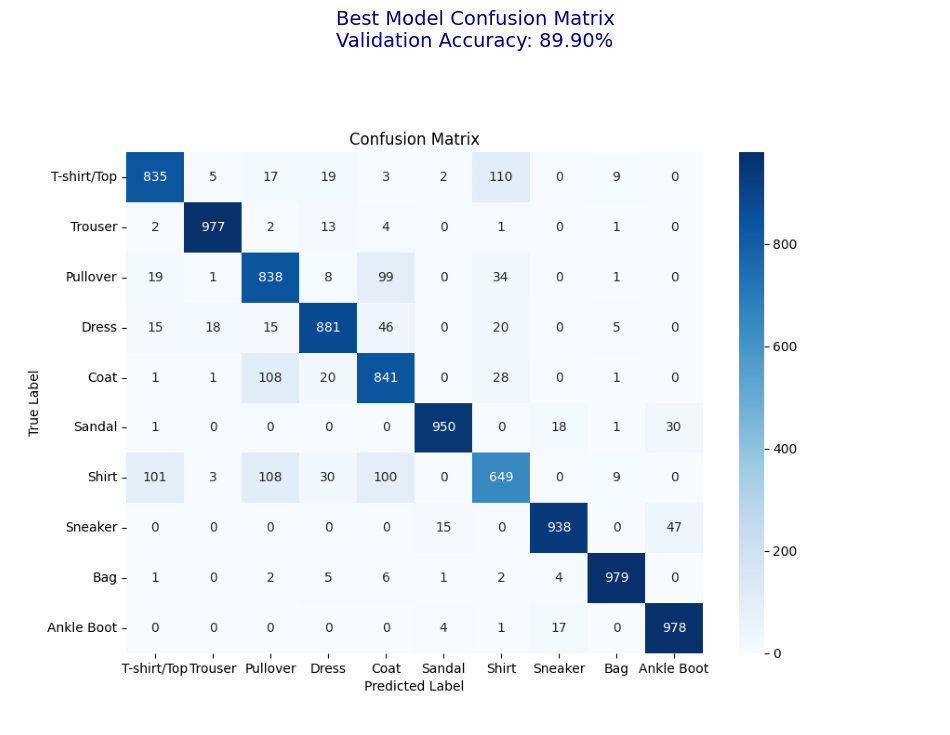

In [38]:
!pip install wandb -q
import wandb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_confusion_matrix():
    wandb.login()

    project_path = "cs24m022-iit-madras-foundation/Deep_Learning_Assignment1_cs24m022"

    try:
        # Fetch best run
        api = wandb.Api()
        sweep = api.sweep(f"{project_path}/{sweep_id}")
        best_run = max(sweep.runs, key=lambda r: r.summary.get("val_accuracy", 0))

        # Get confusion matrix image artifact
        artifact = next(a for a in best_run.logged_artifacts() if "confusion_matrix" in a.name)
        artifact_dir = artifact.download()

        # Load and display image
        img = mpimg.imread(f"{artifact_dir}/confusion_matrix.png")

        # Create styled visualization
        plt.figure(figsize=(12, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Best Model Confusion Matrix\nValidation Accuracy: {best_run.summary['val_accuracy']:.2f}%",
                 pad=20, fontsize=14, color='navy')

        # Save and show
        plt.savefig("final_confusion_matrix.png", bbox_inches='tight', dpi=300)
        plt.show()

        # Log to WandB
        wandb.init(project="Deep_Learning_Assignment1_cs24m022", name="Final_CM_Visualization")
        wandb.log({"Final Confusion Matrix": wandb.Image("final_confusion_matrix.png")})
        wandb.finish()

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the visualization
visualize_confusion_matrix()

Found 448 total runs
Cross Entropy runs: 77, MSE runs: 215
Missing metrics in run civbjhk2
Missing metrics in run bxpyvuf9
Missing metrics in run z1htrhq2
Missing metrics in run qkammgrk
Missing metrics in run 5lsnnnah
Missing metrics in run ady5l9cw
Missing metrics in run r8y8ey0m
Missing metrics in run 5iatpb6q
Missing metrics in run wqdwyb2q
Missing metrics in run xhm6ks3b


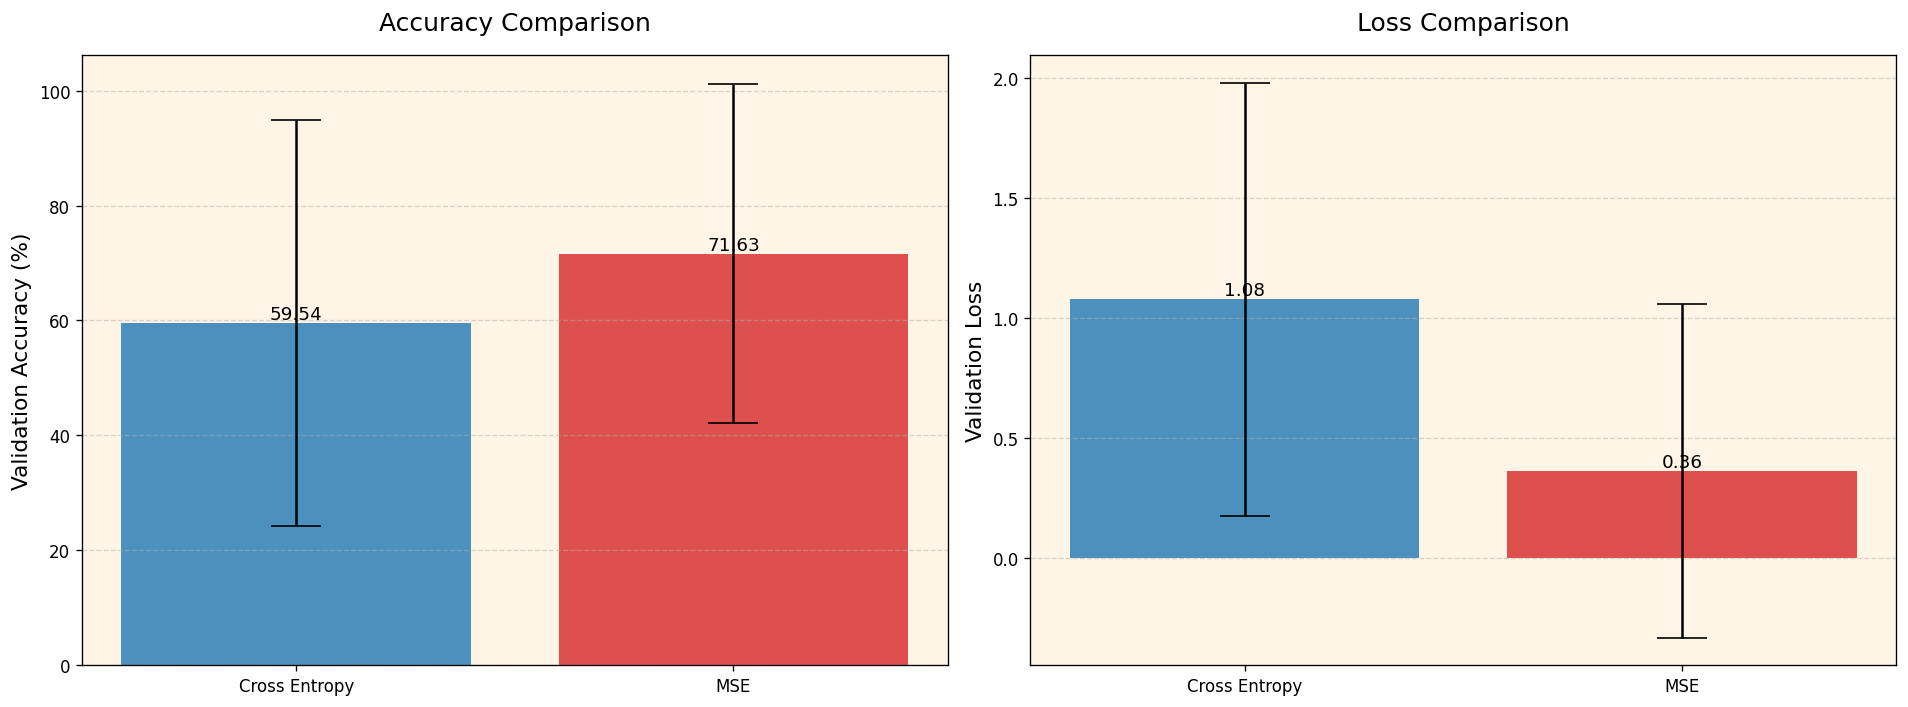

In [48]:
# Cell for Loss Function Comparison
import wandb
import numpy as np
import matplotlib.pyplot as plt

# Initialize WandB connection
wandb.login()
api = wandb.Api()

# Configuration
PROJECT_PATH = "cs24m022-iit-madras-foundation/Deep_Learning_Assignment1_cs24m022"
METRIC_NAMES = ['final_val_accuracy', 'final_val_loss']

try:
    # Fetch runs with error handling
    all_runs = list(api.runs(PROJECT_PATH))
    print(f"Found {len(all_runs)} total runs")

    # Filter runs by loss type
    ce_runs = [r for r in all_runs
              if r.config.get('loss_type', '').lower() == 'cross_entropy']
    mse_runs = [r for r in all_runs
               if r.config.get('loss_type', '').lower() == 'mean_squared_error']

    print(f"Cross Entropy runs: {len(ce_runs)}, MSE runs: {len(mse_runs)}")

    # Metric extraction with validation
    def safe_get_metrics(run_list):
        acc, loss = [], []
        for run in run_list:
            try:
                acc.append(float(run.summary[METRIC_NAMES[0]]))
                loss.append(float(run.summary[METRIC_NAMES[1]]))
            except KeyError:
                print(f"Missing metrics in run {run.id}")
            except Exception as e:
                print(f"Error processing run {run.id}: {str(e)}")
        return acc, loss

    # Get metrics
    ce_acc, ce_loss = safe_get_metrics(ce_runs)
    mse_acc, mse_loss = safe_get_metrics(mse_runs)

    # Calculate statistics
    def calc_stats(values):
        return (np.mean(values), np.std(values)) if values else (np.nan, np.nan)

    ce_acc_mean, ce_acc_std = calc_stats(ce_acc)
    mse_acc_mean, mse_acc_std = calc_stats(mse_acc)
    ce_loss_mean, ce_loss_std = calc_stats(ce_loss)
    mse_loss_mean, mse_loss_std = calc_stats(mse_loss)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=120)

    # Accuracy plot
    ax1.bar(['Cross Entropy', 'MSE'],
           [ce_acc_mean, mse_acc_mean],
           yerr=[ce_acc_std, mse_acc_std],
           color=['#1f77b4', '#d62728'],
           capsize=15, alpha=0.8)
    ax1.set_ylabel('Validation Accuracy (%)', fontsize=13)
    ax1.set_title('Accuracy Comparison', fontsize=15, pad=15)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    # Loss plot
    ax2.bar(['Cross Entropy', 'MSE'],
           [ce_loss_mean, mse_loss_mean],
           yerr=[ce_loss_std, mse_loss_std],
           color=['#1f77b4', '#d62728'],
           capsize=15, alpha=0.8)
    ax2.set_ylabel('Validation Loss', fontsize=13)
    ax2.set_title('Loss Comparison', fontsize=15, pad=15)
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    # Add value labels
    for ax in [ax1, ax2]:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width()/2.,
                   bar.get_height(),
                   f'{bar.get_height():.2f}',
                   ha='center', va='bottom',
                   fontsize=11)

    plt.tight_layout()

    # Log to WandB
    with wandb.init(project=PROJECT_PATH.split("/")[-1],
                  name="loss_comparison",
                  job_type="analysis") as run:
        plt.savefig("loss_comparison.png", bbox_inches='tight')
        wandb.log({"Loss Comparison": wandb.Image("loss_comparison.png")})
        plt.show()